# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy

**"About this file" (source : Kaggle)**

This dataset contains about **10 years of daily weather observations** from numerous **Australian weather stations.**

**RainTomorrow** is the **target variable to predict.** It means -- **did it rain the next day, Yes or No?**

This column is Yes if the rain for that day was 1mm or more.

# I- CNN (Best accuracy : %)

## A. Preprocessing

### The goal is to have 1 continuous time slot $[D_{start},D_{end}]$ without missing days for each city. It will allow a sequential process of all the data by the LSTM model.

In [2]:
data = pd.read_csv("weatherAUS.csv")
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['cos_time'] = np.cos(2*np.pi*(data['Day']+30.5*(data['Month']-1))/365)
data['sin_time'] = np.sin(2*np.pi*(data['Day']+30.5*(data['Month']-1))/365)
data.drop(['Month','Day','Year'], axis=1, inplace = True)

data = data[data["RainTomorrow"].notna()]
data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [3]:
print(f'At the beginning, we have {data.shape[0]} rows')

At the beginning, we have 142193 rows


In [4]:
data.dropna(inplace=True) #On perd complètement les données de plusieurs villes.

In [5]:
print(f'Now, we only have {data.shape[0]} rows')

Now, we only have 56420 rows


In [6]:
data.set_index('Date', inplace=True)

In [7]:
nb_locations = data['Location'].unique().shape[0]
print(f'We keep the data for {nb_locations} cities')

We keep the data for 26 cities


In [8]:
#On garde la fourchette de temps dans laquelle on a le moins de données manquantes
start_date = [data[data['Location'] == location].index.min() for location in data['Location'].unique()]
end_date = [data[data['Location'] == location].index.max() for location in data['Location'].unique()]

In [9]:
#On ajoute les jours manquants
all_locations = data['Location'].unique()
full_data = []
for i, location in enumerate(all_locations):
    all_dates = pd.date_range(start=start_date[i], end=end_date[i], freq='D')
    data_location = data[data['Location'] == location]
    data_location = data_location.reindex(all_dates)
    ### FILLING OF MISSING DATES
    #We do interpolation for continuous variables
    data_location = data_location.interpolate(method='time')
    #For categoric variables, we do a forward fill
    data_location.fillna(method='ffill', inplace=True)
    data_location.drop('Location', axis=1, inplace=True)
    data_location['RainToday'] = data_location['RainToday'].astype('int64')
    data_location['RainTomorrow'] = data_location['RainTomorrow'].astype('int64')
    full_data.append(data_location)
#full_data = pd.concat(full_data)

In [10]:
final_nb_rows = np.array([np.array(full_data[i]).shape[0] for i in range(len(full_data))]).sum()

In [11]:
print(f'full_data gives, for {nb_locations} cities')
print(f'We have {final_nb_rows} rows in total.')

full_data gives, for 26 cities
We have 70613 rows in total.


### One Hot Encoding of categorical variables

In [12]:
numerical = [var for var in full_data[0].columns if full_data[0][var].dtype=='float64']
integer = [var for var in full_data[0].columns if full_data[0][var].dtype=='int64']
categorical = [var for var in full_data[0].columns if full_data[0][var].dtype=='O'] 

In [13]:
for loc_i in range(len(full_data)):
    full_data[loc_i] = pd.concat([full_data[loc_i][numerical+integer], pd.get_dummies(full_data[loc_i][categorical])], axis=1)

### Normalize Data

In [14]:
scaler = StandardScaler()

for loc_i in range(len(full_data)):
    full_data[loc_i][numerical] = scaler.fit_transform(full_data[loc_i][numerical])

In [15]:
for i in range(len(full_data)):
    full_data[i] = full_data[i].astype(np.float32)

In [16]:
full_data[0].head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
2009-01-01,0.631628,1.135731,-0.27596,1.246056,1.008892,1.036222,-1.172212,1.029000,-1.632274,-1.074153,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2009-01-02,0.706128,0.360581,-0.27596,1.882635,1.203186,0.085866,0.940421,0.868461,-1.177524,-1.314399,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2009-01-03,0.780628,0.895803,-0.27596,1.427935,0.870111,0.474648,1.834228,0.547382,-0.904674,-0.978054,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2009-01-04,0.855128,1.431026,-0.27596,0.973236,0.537035,0.863430,2.728034,0.226304,-0.631823,-0.641710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05,1.227627,1.529457,-0.27596,1.109646,0.981136,-0.432511,-1.172212,-1.218549,-0.859199,-0.641710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## B. LSTM_model Class

We will use LSTMs to predict the variable RainTomorrow using the data of a sequence of previous dates's features.

We create a LSTM class that will simplify the test of LSTM models on our dataset.

Later, we will be able to adjust the length of the sequence used to do a prediction, as well as the architecture of the model and the learning parameters.

In [17]:
class CNN_model():
    def __init__(self, name='', full_data=full_data, prev_times=7):
        '''
        Input :     full_data.shape = (nb_cities, nb_days, nb_features)
                    prev_times : number of previous times to consider/ length of the sequence used by the LSTM model
        '''
        self.name = name
        self.prev_times = prev_times
        self.full_data = full_data
        self.data_transformed = False
        self.X_supervised = None
        self.y_supervised = None
        self.model = None
        self.cv = None
        self.history = []
        self.accuracy = []
        self.score = None
        self.model_checkpoint = ModelCheckpoint(f'best_{self.name}/', save_best_only=True, monitor='accuracy', mode='max')
        self.best_model = None

    # convert a dataframe to the "supervised learning" format
    def series_to_supervised(self, x, y, prev_times=7, dropnan=True):
        '''
        Input :     x.shape = (nb_days, nb_features)
                    y.shape = (nb_days,)
                    prev_times : number of previous times to consider

        Output :    x.shape = (nb_days-prev_times, (prev_times+1)*nb_features)
                    y.shape = (nb_days-prev_times,)
        '''
        n_vars = x.shape[1]
        cols, names = list(), list()
        # input sequence (t-prev_times, ..., t)
        for i in range(prev_times, 0, -1):
            cols.append(x.shift(i))
            names += [f'{x.columns[j]}(d-{i})' for j in range(n_vars)]
        cols.append(x)
        names += [f'{x.columns[j]}(d)' for j in range(n_vars)]
        # forecast RainTomorrow(t+1)
        cols.append(y)
        names += ['RainTommorow(d)']
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg.drop('RainTommorow(d)', axis=1), agg['RainTommorow(d)']
    
    #We transform the data to make it compatible with the LSTM model
    def transform_data(self):
        if self.data_transformed:
            return self.X_supervised, self.y_supervised
        X=[]
        y=[]
        for i in range(len(self.full_data)):
            X_city, y_city = self.full_data[i].drop('RainTomorrow', axis=1), self.full_data[i]['RainTomorrow']
            X_city, y_city = self.series_to_supervised(X_city, y_city, self.prev_times)
            X+=X_city.values.tolist()
            y+=y_city.values.tolist()
        X = np.array(X)
        y = np.array(y)
        X = X.reshape((X.shape[0], self.prev_times+1, X.shape[1]//(self.prev_times+1)))
        self.X_supervised = X
        self.y_supervised = y
        self.data_transformed = True
    
    #Define a cross-validation strategy
    def define_cv(self, n_splits=5, shuffle=True, random_state=42):
        '''
        Input :     n_splits : number of folds
        Output :    cv : cross-validation strategy
        '''
        self.cv = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        return self.cv
    
    # design network
    def create_cnn_model(self,nb_layers=1,nb_filters=[64],kernel_sizes=[3],dense_units=8, learning_rate=0.01, print_summary=True):
        '''
        Input :     input_shape : shape of the input
                    nb_layers : number of CNN layers
                    nb_filters : number of filters in each CNN layer
                    learning_rate : learning rate of the optimizer
        Output :    model : CNN model
        '''
        if not self.data_transformed:
            self.transform_data()
        model = Sequential()
        model.add(InputLayer(self.X_supervised.shape[1],self.X_supervised.shape[2]))
        for i in range(nb_layers):
            model.add(Conv1D(filters=nb_filters[i], kernel_size=kernel_sizes[i]))
        model.add(Flatten())
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
        if print_summary:
            print(model.summary())
        return model
    
    #fit one LSTM model with (X_train, y_train)-(X_test, y_test) split
    def fit(self, X_train, X_test, y_train, y_test, epochs=10, batch_size=64, callbacks=None):
        '''
        Input :     callbacks : callbacks to use (for example to keep track of the best model during training)
        Output :    model : fitted LSTM model
        '''
        if self.model is None:
            raise ValueError('You must assign a model before fitting it')
        self.history.append(self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_data=(X_test, y_test)))
        
        return self.model
    
    # evaluate a model using cross-validation
    def evaluate(self, nb_layers=1, nb_filters=[64],dense_units=8, learning_rate= 0.01,n_splits=5,epochs=10, batch_size=64, random_state=42, shuffle=True, use_model_checkpoint=False, reset_model_checkpoint=True):
        '''
        Input :     (nb_layers, nb_filters, learning_rate) : parameters of the CNN model to evaluate
                    (epochs, batch_size) : parameters of the fit method
                    n_splits : number of folds for cross-validation
                    use_model_checkpoint : whether to register the best model during training or not
                    reset_model_checkpoint : whether to reset the model_checkpoint or not (if True, we return the score of the best model during training)
        Output :    score : accuracy score of the model (the one of the best model if reset_model_checkpoint=True & use_model_checkpoint=True, the one of the last model otherwise)
        '''
        self.transform_data() #We make sure that the data is transformed in the right format
        self.history = []
        self.accuracy = []
        callbacks=None
        print_summary = True
        #If we don't use cross-validation
        if n_splits==1:
            if reset_model_checkpoint and use_model_checkpoint: 
                self.initialize_model_checkpoint()
            if use_model_checkpoint:
                callbacks=[self.model_checkpoint]
            X_train, X_test, y_train, y_test = train_test_split(self.X_supervised, self.y_supervised, test_size=0.2, random_state=random_state)
            self.model = self.create_cnn_model(nb_layers=nb_layers, nb_filters=nb_filters,dense_units=dense_units, learning_rate=learning_rate)
            self.fit(X_train, X_test, y_train, y_test, epochs=epochs, batch_size=batch_size, callbacks=callbacks)
            if use_model_checkpoint:
                self.best_model = load_model(f'best_{self.name}/')
            if use_model_checkpoint and reset_model_checkpoint: #If we reset the model_checkpoint, we load the best model
                _, accuracy = self.best_model.evaluate(X_test, y_test, verbose=0)
            else:                                               #Otherwise, we load the last model
                _, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
            self.score = accuracy
            print(f'Accuracy score: {100*self.score:.2f}')
        #If we use cross-validation
        elif n_splits>1:
            self.define_cv(n_splits=n_splits, random_state=random_state, shuffle=True)
            for train_index, test_index in self.cv.split(self.X_supervised, self.y_supervised):
                if reset_model_checkpoint and use_model_checkpoint: 
                    self.initialize_model_checkpoint()
                if use_model_checkpoint:
                    callbacks=[self.model_checkpoint]
                X_train, X_test = self.X_supervised[train_index], self.X_supervised[test_index]
                y_train, y_test = self.y_supervised[train_index], self.y_supervised[test_index] 
                self.model = self.create_cnn_model(nb_layers=nb_layers, nb_filters=nb_filters,dense_units=dense_units, learning_rate=learning_rate, print_summary=print_summary)
                self.fit(X_train, X_test, y_train, y_test, epochs=epochs, batch_size=batch_size, callbacks=callbacks)
                print_summary=False
                if use_model_checkpoint:
                    self.best_model = load_model(f'best_{self.name}/')
                if reset_model_checkpoint and use_model_checkpoint:
                    _, accuracy = self.best_model.evaluate(X_test, y_test, verbose=0)
                else:
                    _, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
                self.accuracy.append(accuracy)
            self.score = np.mean(self.accuracy)
            print(f'Accuracy score: {100*self.score:.2f}')

    # plot history
    def plot_history(self, history, specific_label=''):
        plt.plot(history.history['accuracy'], label='accuracy_train')
        plt.plot(history.history['val_accuracy'], label='accuracy_test')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(specific_label)
        plt.legend()

    # plot history of each training (for each fold)
    def plot_all_history(self, model='LSTM'):
        k = len(self.history)
        plt.figure(figsize=(15, 2*k))
        for i in range(k):
            plt.subplot(k//3+2, 3, i+1)
            self.plot_history(self.history[i], specific_label=f'fold {i+1}')
        plt.suptitle(model + f' Accuracy during training (prev_times={self.prev_times})', fontsize = '15', fontweight='bold')    
        plt.show()
    
    # Reset the model_checkpoint (to keep track of the best model during training)
    def initialize_model_checkpoint(self):
        self.model_checkpoint = ModelCheckpoint(f'best_{self.name}/', save_best_only=True, monitor='val_accuracy', mode='max')

## C. One Location

We keep the data of a single city.

### Data preparation

In [17]:
city = np.random.randint(0,22)
df = [full_data[city]]

### 14 DAYS SEQUENCE : Test on one Train-Test split (accuracy : 88.53%)

In [58]:
lstm_model_city = LSTM_model(name="lstm_model_city",full_data=df, prev_times=14)

In [59]:
lstm_model_city.evaluate(n_splits=1, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 64)                33792     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
197/201 [============================>.] - ETA: 0s - loss: 0.4401 - accuracy: 0.8204INFO:tensorflow:Assets written to: best_lstm_model_city\assets


INFO:tensorflow:Assets written to: best_lstm_model_city\assets


201/201 [==============================] - 12s 38ms/step - loss: 0.4383 - accuracy: 0.8207 - val_loss: 0.3552 - val_accuracy: 0.8479
Epoch 2/6
199/201 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8606INFO:tensorflow:Assets written to: best_lstm_model_city\assets


INFO:tensorflow:Assets written to: best_lstm_model_city\assets


201/201 [==============================] - 9s 47ms/step - loss: 0.3378 - accuracy: 0.8601 - val_loss: 0.3091 - val_accuracy: 0.8778
Epoch 3/6
201/201 [==============================] - 4s 19ms/step - loss: 0.3124 - accuracy: 0.8695 - val_loss: 0.3000 - val_accuracy: 0.8703
Epoch 4/6
199/201 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8763INFO:tensorflow:Assets written to: best_lstm_model_city\assets


INFO:tensorflow:Assets written to: best_lstm_model_city\assets


201/201 [==============================] - 7s 37ms/step - loss: 0.2929 - accuracy: 0.8770 - val_loss: 0.3029 - val_accuracy: 0.8853
Epoch 5/6
201/201 [==============================] - 3s 16ms/step - loss: 0.2788 - accuracy: 0.8819 - val_loss: 0.3088 - val_accuracy: 0.8778
Epoch 6/6
201/201 [==============================] - 3s 17ms/step - loss: 0.2635 - accuracy: 0.8863 - val_loss: 0.2995 - val_accuracy: 0.8778
Accuracy score: 88.53


In [70]:
print(lstm_model_city.name + f' accuracy score : {100*lstm_model_city.score:.2f}')

lstm_model_city accuracy score : 88.53


### 14 DAYS SEQUENCE : Cross-Validation (accuracy : 87.61%)

In [108]:
lstm_model_city_cv = LSTM_model(name="lstm_model_city_cv",full_data=df, prev_times=14)

In [109]:
lstm_model_city_cv.evaluate(n_splits=5, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 64)                33792     
                                                                 
 dense_55 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
196/201 [============================>.] - ETA: 0s - loss: 0.4519 - accuracy: 0.8170INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 8s 25ms/step - loss: 0.4490 - accuracy: 0.8201 - val_loss: 0.3632 - val_accuracy: 0.8753
Epoch 2/6
201/201 [==============================] - 2s 10ms/step - loss: 0.3406 - accuracy: 0.8538 - val_loss: 0.2991 - val_accuracy: 0.8728
Epoch 3/6
196/201 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.8680INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 4s 22ms/step - loss: 0.3094 - accuracy: 0.8682 - val_loss: 0.3060 - val_accuracy: 0.8953
Epoch 4/6
201/201 [==============================] - 2s 10ms/step - loss: 0.2961 - accuracy: 0.8813 - val_loss: 0.3011 - val_accuracy: 0.8903
Epoch 5/6
201/201 [==============================] - 2s 10ms/step - loss: 0.2819 - accuracy: 0.8819 - val_loss: 0.3172 - val_accuracy: 0.8678
Epoch 6/6
201/201 [==============================] - 2s 11ms/step - loss: 0.2661 - accuracy: 0.8869 - val_loss: 0.3158 - val_accuracy: 0.8653
Epoch 1/6
200/201 [============================>.] - ETA: 0s - loss: 0.4123 - accuracy: 0.8188INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 7s 23ms/step - loss: 0.4120 - accuracy: 0.8189 - val_loss: 0.3335 - val_accuracy: 0.8603
Epoch 2/6
201/201 [==============================] - ETA: 0s - loss: 0.3338 - accuracy: 0.8601INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 4s 22ms/step - loss: 0.3338 - accuracy: 0.8601 - val_loss: 0.3240 - val_accuracy: 0.8703
Epoch 3/6
200/201 [============================>.] - ETA: 0s - loss: 0.3111 - accuracy: 0.8719INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 4s 21ms/step - loss: 0.3109 - accuracy: 0.8720 - val_loss: 0.3173 - val_accuracy: 0.8728
Epoch 4/6
201/201 [==============================] - 2s 11ms/step - loss: 0.2953 - accuracy: 0.8757 - val_loss: 0.3080 - val_accuracy: 0.8728
Epoch 5/6
200/201 [============================>.] - ETA: 0s - loss: 0.2845 - accuracy: 0.8781INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 5s 27ms/step - loss: 0.2843 - accuracy: 0.8782 - val_loss: 0.2935 - val_accuracy: 0.8828
Epoch 6/6
201/201 [==============================] - 3s 13ms/step - loss: 0.2723 - accuracy: 0.8813 - val_loss: 0.3086 - val_accuracy: 0.8753
Epoch 1/6
201/201 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.8277INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 15s 30ms/step - loss: 0.4251 - accuracy: 0.8277 - val_loss: 0.3846 - val_accuracy: 0.8500
Epoch 2/6
201/201 [==============================] - 2s 12ms/step - loss: 0.3290 - accuracy: 0.8620 - val_loss: 0.3638 - val_accuracy: 0.8475
Epoch 3/6
201/201 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8777INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 5s 23ms/step - loss: 0.2982 - accuracy: 0.8777 - val_loss: 0.3619 - val_accuracy: 0.8575
Epoch 4/6
201/201 [==============================] - 3s 14ms/step - loss: 0.3244 - accuracy: 0.8764 - val_loss: 0.3584 - val_accuracy: 0.8575
Epoch 5/6
201/201 [==============================] - 2s 10ms/step - loss: 0.2709 - accuracy: 0.8870 - val_loss: 0.3581 - val_accuracy: 0.8475
Epoch 6/6
201/201 [==============================] - 2s 10ms/step - loss: 0.2580 - accuracy: 0.8908 - val_loss: 0.3744 - val_accuracy: 0.8425
Epoch 1/6
198/201 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.8314INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 6s 21ms/step - loss: 0.4054 - accuracy: 0.8302 - val_loss: 0.3565 - val_accuracy: 0.8700
Epoch 2/6
201/201 [==============================] - 2s 10ms/step - loss: 0.3200 - accuracy: 0.8689 - val_loss: 0.3537 - val_accuracy: 0.8625
Epoch 3/6
201/201 [==============================] - 2s 11ms/step - loss: 0.3011 - accuracy: 0.8770 - val_loss: 0.3436 - val_accuracy: 0.8575
Epoch 4/6
201/201 [==============================] - 2s 9ms/step - loss: 0.2856 - accuracy: 0.8814 - val_loss: 0.3386 - val_accuracy: 0.8600
Epoch 5/6
195/201 [============================>.] - ETA: 0s - loss: 0.2741 - accuracy: 0.8923INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 4s 20ms/step - loss: 0.2756 - accuracy: 0.8901 - val_loss: 0.3344 - val_accuracy: 0.8725
Epoch 6/6
201/201 [==============================] - 2s 11ms/step - loss: 0.2563 - accuracy: 0.8933 - val_loss: 0.3325 - val_accuracy: 0.8725
Epoch 1/6
201/201 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8127INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 7s 24ms/step - loss: 0.4226 - accuracy: 0.8127 - val_loss: 0.3384 - val_accuracy: 0.8500
Epoch 2/6
199/201 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8643INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 5s 24ms/step - loss: 0.3438 - accuracy: 0.8639 - val_loss: 0.3220 - val_accuracy: 0.8650
Epoch 3/6
201/201 [==============================] - 2s 11ms/step - loss: 0.3072 - accuracy: 0.8764 - val_loss: 0.3153 - val_accuracy: 0.8575
Epoch 4/6
201/201 [==============================] - 2s 11ms/step - loss: 0.2961 - accuracy: 0.8851 - val_loss: 0.2997 - val_accuracy: 0.8650
Epoch 5/6
199/201 [============================>.] - ETA: 0s - loss: 0.2867 - accuracy: 0.8863INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 4s 22ms/step - loss: 0.2862 - accuracy: 0.8864 - val_loss: 0.2940 - val_accuracy: 0.8675
Epoch 6/6
195/201 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8917INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_city_cv\assets


201/201 [==============================] - 4s 22ms/step - loss: 0.2671 - accuracy: 0.8933 - val_loss: 0.2987 - val_accuracy: 0.8725
Accuracy score: 87.61


In [110]:
print(lstm_model_city_cv.name + f' accuracy score : {100*lstm_model_city_cv.score:.2f}')

lstm_model_city_cv accuracy score : 87.61


## D. Complete Dataset

### Data Preparation

A column is missing in full_data[16], so we add it !

In [18]:
#Identification of a missing columns in one of the cities
set(full_data[17].columns) - set(full_data[16].columns)	

{'WindGustDir_SW'}

In [19]:
#Adding the missing column at the right place
full_data[16].insert(32, 'WindGustDir_SW', 0)

### 7 DAYS SEQUENCE : Cross-Validation (accuracy : 87.99%)

In [ ]:
cnn_model_cv_7 = CNN_model(name="cnn_model_cv_7",full_data=full_data, prev_times=7)

In [ ]:
cnn_model_cv_7.evaluate(n_splits=5, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 64)                33792     
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7043/7043 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8655INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7043/7043 [==============================] - 83s 11ms/step - loss: 0.3156 - accuracy: 0.8655 - val_loss: 0.2975 - val_accuracy: 0.8745
Epoch 2/6
7037/7043 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.8780INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7043/7043 [==============================] - 80s 11ms/step - loss: 0.2868 - accuracy: 0.8779 - val_loss: 0.2885 - val_accuracy: 0.8773
Epoch 3/6
7041/7043 [============================>.] - ETA: 0s - loss: 0.2684 - accuracy: 0.8860INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7043/7043 [==============================] - 87s 12ms/step - loss: 0.2686 - accuracy: 0.8860 - val_loss: 0.2852 - val_accuracy: 0.8790
Epoch 4/6
7043/7043 [==============================] - 85s 12ms/step - loss: 0.2508 - accuracy: 0.8932 - val_loss: 0.2876 - val_accuracy: 0.8781
Epoch 5/6
7043/7043 [==============================] - 91s 13ms/step - loss: 0.2315 - accuracy: 0.9030 - val_loss: 0.2917 - val_accuracy: 0.8773
Epoch 6/6
7043/7043 [==============================] - 86s 12ms/step - loss: 0.2100 - accuracy: 0.9127 - val_loss: 0.3031 - val_accuracy: 0.8766
Epoch 1/6
7041/7044 [============================>.] - ETA: 0s - loss: 0.3172 - accuracy: 0.8659INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 104s 14ms/step - loss: 0.3172 - accuracy: 0.8659 - val_loss: 0.2964 - val_accuracy: 0.8746
Epoch 2/6
7042/7044 [============================>.] - ETA: 0s - loss: 0.2895 - accuracy: 0.8761INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 94s 13ms/step - loss: 0.2895 - accuracy: 0.8761 - val_loss: 0.2818 - val_accuracy: 0.8805
Epoch 3/6
7044/7044 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.8838INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 93s 13ms/step - loss: 0.2726 - accuracy: 0.8838 - val_loss: 0.2772 - val_accuracy: 0.8811
Epoch 4/6
7044/7044 [==============================] - 89s 13ms/step - loss: 0.2550 - accuracy: 0.8904 - val_loss: 0.2818 - val_accuracy: 0.8785
Epoch 5/6
7044/7044 [==============================] - 88s 13ms/step - loss: 0.2368 - accuracy: 0.9002 - val_loss: 0.2822 - val_accuracy: 0.8795
Epoch 6/6
7044/7044 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9099INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 94s 13ms/step - loss: 0.2171 - accuracy: 0.9099 - val_loss: 0.2884 - val_accuracy: 0.8839
Epoch 1/6
7041/7044 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8676INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 98s 13ms/step - loss: 0.3143 - accuracy: 0.8677 - val_loss: 0.3058 - val_accuracy: 0.8702
Epoch 2/6
7041/7044 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.8773INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 96s 14ms/step - loss: 0.2869 - accuracy: 0.8774 - val_loss: 0.2964 - val_accuracy: 0.8735
Epoch 3/6
7044/7044 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.8838INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 92s 13ms/step - loss: 0.2691 - accuracy: 0.8838 - val_loss: 0.2952 - val_accuracy: 0.8745
Epoch 4/6
7044/7044 [==============================] - 90s 13ms/step - loss: 0.2514 - accuracy: 0.8946 - val_loss: 0.2924 - val_accuracy: 0.8744
Epoch 5/6
7043/7044 [============================>.] - ETA: 0s - loss: 0.2323 - accuracy: 0.9013INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 93s 13ms/step - loss: 0.2323 - accuracy: 0.9013 - val_loss: 0.3035 - val_accuracy: 0.8774
Epoch 6/6
7044/7044 [==============================] - 91s 13ms/step - loss: 0.2123 - accuracy: 0.9106 - val_loss: 0.3055 - val_accuracy: 0.8770
Epoch 1/6
7043/7044 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.8673INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 97s 13ms/step - loss: 0.3137 - accuracy: 0.8673 - val_loss: 0.2922 - val_accuracy: 0.8755
Epoch 2/6
7041/7044 [============================>.] - ETA: 0s - loss: 0.2860 - accuracy: 0.8783INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 92s 13ms/step - loss: 0.2860 - accuracy: 0.8783 - val_loss: 0.2842 - val_accuracy: 0.8780
Epoch 3/6
7044/7044 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.8858INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 88s 12ms/step - loss: 0.2690 - accuracy: 0.8858 - val_loss: 0.2839 - val_accuracy: 0.8798
Epoch 4/6
7042/7044 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.8920INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 96s 14ms/step - loss: 0.2516 - accuracy: 0.8920 - val_loss: 0.2829 - val_accuracy: 0.8829
Epoch 5/6
7040/7044 [============================>.] - ETA: 0s - loss: 0.2333 - accuracy: 0.9020INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 93s 13ms/step - loss: 0.2334 - accuracy: 0.9020 - val_loss: 0.2888 - val_accuracy: 0.8831
Epoch 6/6
7041/7044 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9104INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 112s 16ms/step - loss: 0.2134 - accuracy: 0.9104 - val_loss: 0.2899 - val_accuracy: 0.8837
Epoch 1/6
7040/7044 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8677INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 106s 15ms/step - loss: 0.3146 - accuracy: 0.8677 - val_loss: 0.3022 - val_accuracy: 0.8714
Epoch 2/6
7044/7044 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.8780INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 106s 15ms/step - loss: 0.2866 - accuracy: 0.8780 - val_loss: 0.2929 - val_accuracy: 0.8745
Epoch 3/6
7044/7044 [==============================] - 98s 14ms/step - loss: 0.2693 - accuracy: 0.8849 - val_loss: 0.2912 - val_accuracy: 0.8741
Epoch 4/6
7044/7044 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.8926INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 102s 15ms/step - loss: 0.2511 - accuracy: 0.8926 - val_loss: 0.2902 - val_accuracy: 0.8753
Epoch 5/6
7042/7044 [============================>.] - ETA: 0s - loss: 0.2324 - accuracy: 0.9017INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_7\assets


7044/7044 [==============================] - 102s 14ms/step - loss: 0.2324 - accuracy: 0.9017 - val_loss: 0.2950 - val_accuracy: 0.8756
Epoch 6/6
7044/7044 [==============================] - 96s 14ms/step - loss: 0.2124 - accuracy: 0.9117 - val_loss: 0.3053 - val_accuracy: 0.8716
Accuracy score: 87.99


In [ ]:
print(cnn_model_cv_7.name + f' accuracy score : {100*cnn_model_cv_7.score:.2f}')

lstm_model_cv_7 accuracy score : 87.99


### 14 DAYS SEQUENCE : Test on one Train-Test split (accuracy : 87.67%)

### 14 DAYS SEQUENCE : Cross-Validation (accuracy : 88.20%)

In [ ]:
cnn_model_cv_14_0 = CNN_model(name="cnn_model_cv_14_0",full_data=full_data, prev_times=14)

In [ ]:
cnn_model_cv_14_0.evaluate(n_splits=5, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                33792     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7025/7025 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.8681INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 79s 11ms/step - loss: 0.3140 - accuracy: 0.8681 - val_loss: 0.2898 - val_accuracy: 0.8763
Epoch 2/6
7022/7025 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8786INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 74s 10ms/step - loss: 0.2872 - accuracy: 0.8786 - val_loss: 0.2816 - val_accuracy: 0.8765
Epoch 3/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.8861INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 73s 10ms/step - loss: 0.2700 - accuracy: 0.8860 - val_loss: 0.2786 - val_accuracy: 0.8787
Epoch 4/6
7025/7025 [==============================] - 70s 10ms/step - loss: 0.2536 - accuracy: 0.8920 - val_loss: 0.2784 - val_accuracy: 0.8787
Epoch 5/6
7025/7025 [==============================] - 69s 10ms/step - loss: 0.2364 - accuracy: 0.9012 - val_loss: 0.2860 - val_accuracy: 0.8769
Epoch 6/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9084INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 75s 11ms/step - loss: 0.2188 - accuracy: 0.9084 - val_loss: 0.2864 - val_accuracy: 0.8789
Epoch 1/6
7020/7025 [============================>.] - ETA: 0s - loss: 0.3126 - accuracy: 0.8688INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 80s 11ms/step - loss: 0.3127 - accuracy: 0.8688 - val_loss: 0.2969 - val_accuracy: 0.8752
Epoch 2/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.8778INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 74s 11ms/step - loss: 0.2858 - accuracy: 0.8778 - val_loss: 0.2874 - val_accuracy: 0.8763
Epoch 3/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2678 - accuracy: 0.8848INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 75s 11ms/step - loss: 0.2678 - accuracy: 0.8848 - val_loss: 0.2843 - val_accuracy: 0.8785
Epoch 4/6
7022/7025 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.8923INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 72s 10ms/step - loss: 0.2518 - accuracy: 0.8923 - val_loss: 0.2815 - val_accuracy: 0.8801
Epoch 5/6
7022/7025 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.8990INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 74s 11ms/step - loss: 0.2367 - accuracy: 0.8991 - val_loss: 0.2812 - val_accuracy: 0.8816
Epoch 6/6
7025/7025 [==============================] - 70s 10ms/step - loss: 0.2176 - accuracy: 0.9088 - val_loss: 0.2925 - val_accuracy: 0.8797
Epoch 1/6
7025/7025 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8685INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 77s 11ms/step - loss: 0.3138 - accuracy: 0.8685 - val_loss: 0.2991 - val_accuracy: 0.8716
Epoch 2/6
7021/7025 [============================>.] - ETA: 0s - loss: 0.2852 - accuracy: 0.8788INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 74s 10ms/step - loss: 0.2853 - accuracy: 0.8787 - val_loss: 0.2889 - val_accuracy: 0.8770
Epoch 3/6
7022/7025 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8852INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 72s 10ms/step - loss: 0.2693 - accuracy: 0.8852 - val_loss: 0.2860 - val_accuracy: 0.8781
Epoch 4/6
7025/7025 [==============================] - 68s 10ms/step - loss: 0.2532 - accuracy: 0.8921 - val_loss: 0.2863 - val_accuracy: 0.8779
Epoch 5/6
7022/7025 [============================>.] - ETA: 0s - loss: 0.2353 - accuracy: 0.9005INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 71s 10ms/step - loss: 0.2354 - accuracy: 0.9005 - val_loss: 0.2873 - val_accuracy: 0.8791
Epoch 6/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.2190 - accuracy: 0.9079INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 71s 10ms/step - loss: 0.2190 - accuracy: 0.9079 - val_loss: 0.2901 - val_accuracy: 0.8809
Epoch 1/6
7022/7025 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.8666INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 76s 10ms/step - loss: 0.3122 - accuracy: 0.8665 - val_loss: 0.3012 - val_accuracy: 0.8752
Epoch 2/6
7020/7025 [============================>.] - ETA: 0s - loss: 0.2839 - accuracy: 0.8786INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 78s 11ms/step - loss: 0.2839 - accuracy: 0.8786 - val_loss: 0.2869 - val_accuracy: 0.8794
Epoch 3/6
7021/7025 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 78s 11ms/step - loss: 0.2660 - accuracy: 0.8853 - val_loss: 0.2863 - val_accuracy: 0.8811
Epoch 4/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.2499 - accuracy: 0.8922INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 83s 12ms/step - loss: 0.2499 - accuracy: 0.8922 - val_loss: 0.2852 - val_accuracy: 0.8843
Epoch 5/6
7025/7025 [==============================] - 76s 11ms/step - loss: 0.2319 - accuracy: 0.9018 - val_loss: 0.2925 - val_accuracy: 0.8801
Epoch 6/6
7025/7025 [==============================] - 74s 11ms/step - loss: 0.2133 - accuracy: 0.9104 - val_loss: 0.2939 - val_accuracy: 0.8831
Epoch 1/6
7019/7025 [============================>.] - ETA: 0s - loss: 0.3136 - accuracy: 0.8664INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 66s 9ms/step - loss: 0.3134 - accuracy: 0.8665 - val_loss: 0.2921 - val_accuracy: 0.8771
Epoch 2/6
7025/7025 [==============================] - 59s 8ms/step - loss: 0.2854 - accuracy: 0.8781 - val_loss: 0.2868 - val_accuracy: 0.8771
Epoch 3/6
7020/7025 [============================>.] - ETA: 0s - loss: 0.2685 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 63s 9ms/step - loss: 0.2684 - accuracy: 0.8853 - val_loss: 0.2790 - val_accuracy: 0.8784
Epoch 4/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2509 - accuracy: 0.8934INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 62s 9ms/step - loss: 0.2509 - accuracy: 0.8934 - val_loss: 0.2776 - val_accuracy: 0.8813
Epoch 5/6
7021/7025 [============================>.] - ETA: 0s - loss: 0.2336 - accuracy: 0.9019INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 62s 9ms/step - loss: 0.2337 - accuracy: 0.9019 - val_loss: 0.2783 - val_accuracy: 0.8840
Epoch 6/6
7025/7025 [==============================] - 57s 8ms/step - loss: 0.2144 - accuracy: 0.9114 - val_loss: 0.2877 - val_accuracy: 0.8780
Accuracy score: 88.20


In [ ]:
print(cnn_model_cv_14_0.name + f' accuracy score : {100*cnn_model_cv_14_0.score:.2f}')

lstm_model_cv accuracy score : 88.20


### 14 DAYS SEQUENCE AND 2 LSTM LAYERS : Cross-Validation (88.06%)

In [82]:
cnn_model_cv_14_1 = CNN_model(name="cnn_model_cv_14_1",full_data=full_data, prev_times=14)

In [83]:
cnn_model_cv_14_1.evaluate(n_splits=5, learning_rate=0.001, nb_layers=2, nb_neurons=[64,32], epochs=6, batch_size=8, use_model_checkpoint=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 15, 64)            33792     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 46241 (180.63 KB)
Trainable params: 46241 (180.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7025/7025 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.8653INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 134s 18ms/step - loss: 0.3191 - accuracy: 0.8653 - val_loss: 0.2937 - val_accuracy: 0.8725
Epoch 2/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8778INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 126s 18ms/step - loss: 0.2873 - accuracy: 0.8778 - val_loss: 0.2871 - val_accuracy: 0.8763
Epoch 3/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.8848INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 126s 18ms/step - loss: 0.2694 - accuracy: 0.8848 - val_loss: 0.2805 - val_accuracy: 0.8782
Epoch 4/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.8939INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 125s 18ms/step - loss: 0.2516 - accuracy: 0.8939 - val_loss: 0.2791 - val_accuracy: 0.8791
Epoch 5/6
7022/7025 [============================>.] - ETA: 0s - loss: 0.2321 - accuracy: 0.9020INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 124s 18ms/step - loss: 0.2320 - accuracy: 0.9020 - val_loss: 0.2871 - val_accuracy: 0.8825
Epoch 6/6
7025/7025 [==============================] - 109s 15ms/step - loss: 0.2109 - accuracy: 0.9130 - val_loss: 0.3053 - val_accuracy: 0.8794
Epoch 1/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.3177 - accuracy: 0.8657INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 122s 17ms/step - loss: 0.3178 - accuracy: 0.8657 - val_loss: 0.2982 - val_accuracy: 0.8712
Epoch 2/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.2858 - accuracy: 0.8781INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 115s 16ms/step - loss: 0.2858 - accuracy: 0.8781 - val_loss: 0.2863 - val_accuracy: 0.8774
Epoch 3/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.2684 - accuracy: 0.8857INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 132s 19ms/step - loss: 0.2684 - accuracy: 0.8858 - val_loss: 0.2833 - val_accuracy: 0.8780
Epoch 4/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.8923INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 147s 21ms/step - loss: 0.2493 - accuracy: 0.8923 - val_loss: 0.2834 - val_accuracy: 0.8806
Epoch 5/6
7025/7025 [==============================] - 138s 20ms/step - loss: 0.2313 - accuracy: 0.9023 - val_loss: 0.2879 - val_accuracy: 0.8774
Epoch 6/6
7025/7025 [==============================] - 152s 22ms/step - loss: 0.2104 - accuracy: 0.9119 - val_loss: 0.2971 - val_accuracy: 0.8725
Epoch 1/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.3167 - accuracy: 0.8661INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 146s 20ms/step - loss: 0.3167 - accuracy: 0.8661 - val_loss: 0.2997 - val_accuracy: 0.8716
Epoch 2/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2843 - accuracy: 0.8788INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 136s 19ms/step - loss: 0.2843 - accuracy: 0.8788 - val_loss: 0.2888 - val_accuracy: 0.8755
Epoch 3/6
7025/7025 [==============================] - 142s 20ms/step - loss: 0.2669 - accuracy: 0.8865 - val_loss: 0.2926 - val_accuracy: 0.8752
Epoch 4/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.2481 - accuracy: 0.8947INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 145s 21ms/step - loss: 0.2481 - accuracy: 0.8947 - val_loss: 0.2903 - val_accuracy: 0.8784
Epoch 5/6
7025/7025 [==============================] - 141s 20ms/step - loss: 0.2293 - accuracy: 0.9029 - val_loss: 0.2972 - val_accuracy: 0.8752
Epoch 6/6
7025/7025 [==============================] - 141s 20ms/step - loss: 0.2084 - accuracy: 0.9131 - val_loss: 0.3077 - val_accuracy: 0.8725
Epoch 1/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.3157 - accuracy: 0.8660INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 153s 21ms/step - loss: 0.3157 - accuracy: 0.8661 - val_loss: 0.2989 - val_accuracy: 0.8754
Epoch 2/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2845 - accuracy: 0.8790INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 130s 19ms/step - loss: 0.2845 - accuracy: 0.8790 - val_loss: 0.2889 - val_accuracy: 0.8785
Epoch 3/6
7022/7025 [============================>.] - ETA: 0s - loss: 0.2662 - accuracy: 0.8854INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 124s 18ms/step - loss: 0.2662 - accuracy: 0.8854 - val_loss: 0.2870 - val_accuracy: 0.8804
Epoch 4/6
7025/7025 [==============================] - 129s 18ms/step - loss: 0.2470 - accuracy: 0.8937 - val_loss: 0.2888 - val_accuracy: 0.8784
Epoch 5/6
7025/7025 [==============================] - 129s 18ms/step - loss: 0.2258 - accuracy: 0.9047 - val_loss: 0.2906 - val_accuracy: 0.8789
Epoch 6/6
7025/7025 [==============================] - 137s 19ms/step - loss: 0.2034 - accuracy: 0.9154 - val_loss: 0.3129 - val_accuracy: 0.8778
Epoch 1/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8659INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 138s 19ms/step - loss: 0.3178 - accuracy: 0.8659 - val_loss: 0.2915 - val_accuracy: 0.8781
Epoch 2/6
7025/7025 [==============================] - 121s 17ms/step - loss: 0.2862 - accuracy: 0.8782 - val_loss: 0.2863 - val_accuracy: 0.8769
Epoch 3/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2684 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv\assets


7025/7025 [==============================] - 129s 18ms/step - loss: 0.2684 - accuracy: 0.8852 - val_loss: 0.2845 - val_accuracy: 0.8810
Epoch 4/6
7025/7025 [==============================] - 121s 17ms/step - loss: 0.2505 - accuracy: 0.8935 - val_loss: 0.2818 - val_accuracy: 0.8796
Epoch 5/6
7025/7025 [==============================] - 121s 17ms/step - loss: 0.2298 - accuracy: 0.9015 - val_loss: 0.2893 - val_accuracy: 0.8799
Epoch 6/6
7025/7025 [==============================] - 122s 17ms/step - loss: 0.2089 - accuracy: 0.9130 - val_loss: 0.2921 - val_accuracy: 0.8768
Accuracy score: 88.06


In [84]:

print(cnn_model_cv_14_1.name + f' accuracy score : {100*cnn_model_cv_14_1.score:.2f}')

lstm_model_cv accuracy score : 88.06


### 8-38 DAYS SEQUENCE : Cross-Validation (accuracy : 88.18%)

In [115]:
nb_prev_times = [8,10,12,14,16,18,20,22]
accuracy = [0,0,0,0,0,0,0,0]

In [116]:
for i, prev_times in enumerate(nb_prev_times):
    cnn_model_cv = CNN_model(name=f"lstm_model_cv_{prev_times}",full_data=full_data, prev_times=prev_times)
    cnn_model_cv.evaluate(n_splits=5, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)
    accuracy[i] = cnn_model_cv.score

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 64)                33792     
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7039/7041 [============================>.] - ETA: 0s - loss: 0.3131 - accuracy: 0.8681INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 137s 19ms/step - loss: 0.3131 - accuracy: 0.8682 - val_loss: 0.3041 - val_accuracy: 0.8714
Epoch 2/6
7039/7041 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8788INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 128s 18ms/step - loss: 0.2861 - accuracy: 0.8788 - val_loss: 0.3018 - val_accuracy: 0.8750
Epoch 3/6
7039/7041 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8835INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 128s 18ms/step - loss: 0.2693 - accuracy: 0.8835 - val_loss: 0.2920 - val_accuracy: 0.8765
Epoch 4/6
7041/7041 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.8926INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 125s 18ms/step - loss: 0.2520 - accuracy: 0.8926 - val_loss: 0.2911 - val_accuracy: 0.8801
Epoch 5/6
7041/7041 [==============================] - 137s 19ms/step - loss: 0.2326 - accuracy: 0.9016 - val_loss: 0.2930 - val_accuracy: 0.8785
Epoch 6/6
7041/7041 [==============================] - 142s 20ms/step - loss: 0.2130 - accuracy: 0.9110 - val_loss: 0.3017 - val_accuracy: 0.8760
Epoch 1/6
7040/7041 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8673INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 127s 17ms/step - loss: 0.3162 - accuracy: 0.8673 - val_loss: 0.2996 - val_accuracy: 0.8700
Epoch 2/6
7040/7041 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8777INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 118s 17ms/step - loss: 0.2892 - accuracy: 0.8777 - val_loss: 0.2879 - val_accuracy: 0.8759
Epoch 3/6
7040/7041 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.8851INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 119s 17ms/step - loss: 0.2724 - accuracy: 0.8850 - val_loss: 0.2871 - val_accuracy: 0.8763
Epoch 4/6
7039/7041 [============================>.] - ETA: 0s - loss: 0.2561 - accuracy: 0.8917INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 121s 17ms/step - loss: 0.2561 - accuracy: 0.8918 - val_loss: 0.2874 - val_accuracy: 0.8775
Epoch 5/6
7040/7041 [============================>.] - ETA: 0s - loss: 0.2382 - accuracy: 0.8997INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 136s 19ms/step - loss: 0.2382 - accuracy: 0.8997 - val_loss: 0.2878 - val_accuracy: 0.8783
Epoch 6/6
7041/7041 [==============================] - 107s 15ms/step - loss: 0.2195 - accuracy: 0.9083 - val_loss: 0.2967 - val_accuracy: 0.8781
Epoch 1/6
7040/7041 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8666INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 111s 15ms/step - loss: 0.3152 - accuracy: 0.8666 - val_loss: 0.2964 - val_accuracy: 0.8771
Epoch 2/6
7040/7041 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.8770INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 102s 14ms/step - loss: 0.2869 - accuracy: 0.8770 - val_loss: 0.2869 - val_accuracy: 0.8810
Epoch 3/6
7039/7041 [============================>.] - ETA: 0s - loss: 0.2705 - accuracy: 0.8838INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 102s 14ms/step - loss: 0.2705 - accuracy: 0.8838 - val_loss: 0.2834 - val_accuracy: 0.8819
Epoch 4/6
7041/7041 [==============================] - 98s 14ms/step - loss: 0.2531 - accuracy: 0.8914 - val_loss: 0.2848 - val_accuracy: 0.8805
Epoch 5/6
7041/7041 [==============================] - 97s 14ms/step - loss: 0.2349 - accuracy: 0.9003 - val_loss: 0.2892 - val_accuracy: 0.8813
Epoch 6/6
7041/7041 [==============================] - 97s 14ms/step - loss: 0.2162 - accuracy: 0.9102 - val_loss: 0.2964 - val_accuracy: 0.8796
Epoch 1/6
7041/7041 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8672INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 125s 17ms/step - loss: 0.3153 - accuracy: 0.8672 - val_loss: 0.3000 - val_accuracy: 0.8724
Epoch 2/6
7041/7041 [==============================] - ETA: 0s - loss: 0.2880 - accuracy: 0.8768INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 146s 21ms/step - loss: 0.2880 - accuracy: 0.8768 - val_loss: 0.2894 - val_accuracy: 0.8748
Epoch 3/6
7041/7041 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8842INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 134s 19ms/step - loss: 0.2710 - accuracy: 0.8842 - val_loss: 0.2839 - val_accuracy: 0.8776
Epoch 4/6
7039/7041 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.8918INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 133s 19ms/step - loss: 0.2537 - accuracy: 0.8918 - val_loss: 0.2870 - val_accuracy: 0.8794
Epoch 5/6
7041/7041 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9006INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 136s 19ms/step - loss: 0.2355 - accuracy: 0.9006 - val_loss: 0.2835 - val_accuracy: 0.8801
Epoch 6/6
7041/7041 [==============================] - 114s 16ms/step - loss: 0.2155 - accuracy: 0.9098 - val_loss: 0.2920 - val_accuracy: 0.8801
Epoch 1/6
7039/7041 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8685INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 131s 18ms/step - loss: 0.3144 - accuracy: 0.8685 - val_loss: 0.2962 - val_accuracy: 0.8742
Epoch 2/6
7040/7041 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.8788INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 107s 15ms/step - loss: 0.2863 - accuracy: 0.8788 - val_loss: 0.2885 - val_accuracy: 0.8771
Epoch 3/6
7041/7041 [==============================] - 102s 14ms/step - loss: 0.2687 - accuracy: 0.8854 - val_loss: 0.2888 - val_accuracy: 0.8747
Epoch 4/6
7041/7041 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.8944INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_8\assets


7041/7041 [==============================] - 107s 15ms/step - loss: 0.2515 - accuracy: 0.8944 - val_loss: 0.2910 - val_accuracy: 0.8773
Epoch 5/6
7041/7041 [==============================] - 102s 15ms/step - loss: 0.2341 - accuracy: 0.9023 - val_loss: 0.2919 - val_accuracy: 0.8767
Epoch 6/6
7041/7041 [==============================] - 102s 14ms/step - loss: 0.2144 - accuracy: 0.9104 - val_loss: 0.2974 - val_accuracy: 0.8756
Accuracy score: 87.95
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 64)                33792     
                                                                 
 dense_42 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 127s 18ms/step - loss: 0.3146 - accuracy: 0.8672 - val_loss: 0.2901 - val_accuracy: 0.8739
Epoch 2/6
7034/7036 [============================>.] - ETA: 0s - loss: 0.2858 - accuracy: 0.8782INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 121s 17ms/step - loss: 0.2858 - accuracy: 0.8782 - val_loss: 0.2819 - val_accuracy: 0.8806
Epoch 3/6
7036/7036 [==============================] - 117s 17ms/step - loss: 0.2695 - accuracy: 0.8861 - val_loss: 0.2791 - val_accuracy: 0.8802
Epoch 4/6
7036/7036 [==============================] - 117s 17ms/step - loss: 0.2519 - accuracy: 0.8933 - val_loss: 0.2840 - val_accuracy: 0.8774
Epoch 5/6
7036/7036 [==============================] - 116s 17ms/step - loss: 0.2351 - accuracy: 0.9015 - val_loss: 0.2855 - val_accuracy: 0.8779
Epoch 6/6
7035/7036 [============================>.] - ETA: 0s - loss: 0.2159 - accuracy: 0.9100INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 121s 17ms/step - loss: 0.2159 - accuracy: 0.9100 - val_loss: 0.2950 - val_accuracy: 0.8812
Epoch 1/6
7035/7036 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8678INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 124s 17ms/step - loss: 0.3141 - accuracy: 0.8678 - val_loss: 0.3000 - val_accuracy: 0.8739
Epoch 2/6
7036/7036 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8785INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 120s 17ms/step - loss: 0.2861 - accuracy: 0.8785 - val_loss: 0.2916 - val_accuracy: 0.8747
Epoch 3/6
7034/7036 [============================>.] - ETA: 0s - loss: 0.2687 - accuracy: 0.8851INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 121s 17ms/step - loss: 0.2688 - accuracy: 0.8851 - val_loss: 0.2911 - val_accuracy: 0.8768
Epoch 4/6
7036/7036 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.8929INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 140s 20ms/step - loss: 0.2519 - accuracy: 0.8929 - val_loss: 0.2877 - val_accuracy: 0.8814
Epoch 5/6
7036/7036 [==============================] - 120s 17ms/step - loss: 0.2339 - accuracy: 0.9028 - val_loss: 0.2912 - val_accuracy: 0.8793
Epoch 6/6
7036/7036 [==============================] - 119s 17ms/step - loss: 0.2152 - accuracy: 0.9109 - val_loss: 0.3031 - val_accuracy: 0.8799
Epoch 1/6
7036/7036 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8676INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 139s 19ms/step - loss: 0.3126 - accuracy: 0.8676 - val_loss: 0.2966 - val_accuracy: 0.8740
Epoch 2/6
7036/7036 [==============================] - 132s 19ms/step - loss: 0.2850 - accuracy: 0.8790 - val_loss: 0.2974 - val_accuracy: 0.8735
Epoch 3/6
7036/7036 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 136s 19ms/step - loss: 0.2677 - accuracy: 0.8853 - val_loss: 0.2867 - val_accuracy: 0.8774
Epoch 4/6
7034/7036 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.8929INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 138s 20ms/step - loss: 0.2516 - accuracy: 0.8929 - val_loss: 0.2838 - val_accuracy: 0.8775
Epoch 5/6
7036/7036 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9011INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 136s 19ms/step - loss: 0.2342 - accuracy: 0.9011 - val_loss: 0.2894 - val_accuracy: 0.8780
Epoch 6/6
7036/7036 [==============================] - 132s 19ms/step - loss: 0.2154 - accuracy: 0.9100 - val_loss: 0.2963 - val_accuracy: 0.8772
Epoch 1/6
7036/7036 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8665INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 142s 20ms/step - loss: 0.3128 - accuracy: 0.8665 - val_loss: 0.2954 - val_accuracy: 0.8765
Epoch 2/6
7036/7036 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8771INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 138s 20ms/step - loss: 0.2850 - accuracy: 0.8771 - val_loss: 0.2870 - val_accuracy: 0.8783
Epoch 3/6
7036/7036 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 138s 20ms/step - loss: 0.2678 - accuracy: 0.8853 - val_loss: 0.2845 - val_accuracy: 0.8792
Epoch 4/6
7036/7036 [==============================] - 134s 19ms/step - loss: 0.2503 - accuracy: 0.8940 - val_loss: 0.2856 - val_accuracy: 0.8785
Epoch 5/6
7035/7036 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.9011INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 138s 20ms/step - loss: 0.2319 - accuracy: 0.9011 - val_loss: 0.2857 - val_accuracy: 0.8797
Epoch 6/6
7036/7036 [==============================] - 133s 19ms/step - loss: 0.2121 - accuracy: 0.9115 - val_loss: 0.2940 - val_accuracy: 0.8792
Epoch 1/6
7035/7036 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8687INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 151s 21ms/step - loss: 0.3143 - accuracy: 0.8687 - val_loss: 0.2964 - val_accuracy: 0.8729
Epoch 2/6
7035/7036 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8780INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 131s 19ms/step - loss: 0.2853 - accuracy: 0.8780 - val_loss: 0.2886 - val_accuracy: 0.8742
Epoch 3/6
7036/7036 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8869INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 130s 19ms/step - loss: 0.2682 - accuracy: 0.8869 - val_loss: 0.2841 - val_accuracy: 0.8777
Epoch 4/6
7034/7036 [============================>.] - ETA: 0s - loss: 0.2515 - accuracy: 0.8940INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 131s 19ms/step - loss: 0.2516 - accuracy: 0.8939 - val_loss: 0.2837 - val_accuracy: 0.8778
Epoch 5/6
7036/7036 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 0.9022INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_10\assets


7036/7036 [==============================] - 134s 19ms/step - loss: 0.2339 - accuracy: 0.9022 - val_loss: 0.2887 - val_accuracy: 0.8787
Epoch 6/6
7036/7036 [==============================] - 126s 18ms/step - loss: 0.2144 - accuracy: 0.9118 - val_loss: 0.2978 - val_accuracy: 0.8754
Accuracy score: 87.98
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 64)                33792     
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7029/7030 [============================>.] - ETA: 0s - loss: 0.3134 - accuracy: 0.8663INFO:t

INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7030/7030 [==============================] - 143s 20ms/step - loss: 0.3134 - accuracy: 0.8663 - val_loss: 0.2960 - val_accuracy: 0.8746
Epoch 2/6
7029/7030 [============================>.] - ETA: 0s - loss: 0.2854 - accuracy: 0.8782INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7030/7030 [==============================] - 138s 20ms/step - loss: 0.2854 - accuracy: 0.8782 - val_loss: 0.2857 - val_accuracy: 0.8794
Epoch 3/6
7030/7030 [==============================] - 134s 19ms/step - loss: 0.2689 - accuracy: 0.8853 - val_loss: 0.2845 - val_accuracy: 0.8792
Epoch 4/6
7030/7030 [==============================] - 135s 19ms/step - loss: 0.2528 - accuracy: 0.8916 - val_loss: 0.2855 - val_accuracy: 0.8775
Epoch 5/6
7030/7030 [==============================] - 134s 19ms/step - loss: 0.2355 - accuracy: 0.9005 - val_loss: 0.2838 - val_accuracy: 0.8792
Epoch 6/6
7030/7030 [==============================] - 134s 19ms/step - loss: 0.2179 - accuracy: 0.9085 - val_loss: 0.2924 - val_accuracy: 0.8794
Epoch 1/6
7029/7031 [============================>.] - ETA: 0s - loss: 0.3132 - accuracy: 0.8686INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 147s 21ms/step - loss: 0.3132 - accuracy: 0.8686 - val_loss: 0.2969 - val_accuracy: 0.8737
Epoch 2/6
7029/7031 [============================>.] - ETA: 0s - loss: 0.2855 - accuracy: 0.8798INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 144s 20ms/step - loss: 0.2855 - accuracy: 0.8799 - val_loss: 0.2866 - val_accuracy: 0.8768
Epoch 3/6
7031/7031 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.8864INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 144s 20ms/step - loss: 0.2676 - accuracy: 0.8864 - val_loss: 0.2854 - val_accuracy: 0.8772
Epoch 4/6
7031/7031 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.8933INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 170s 24ms/step - loss: 0.2500 - accuracy: 0.8933 - val_loss: 0.2818 - val_accuracy: 0.8795
Epoch 5/6
7031/7031 [==============================] - 145s 21ms/step - loss: 0.2313 - accuracy: 0.9038 - val_loss: 0.2881 - val_accuracy: 0.8785
Epoch 6/6
7031/7031 [==============================] - 145s 21ms/step - loss: 0.2115 - accuracy: 0.9123 - val_loss: 0.2975 - val_accuracy: 0.8777
Epoch 1/6
7030/7031 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8670INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 163s 23ms/step - loss: 0.3141 - accuracy: 0.8670 - val_loss: 0.2993 - val_accuracy: 0.8735
Epoch 2/6
7031/7031 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8780INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 158s 23ms/step - loss: 0.2869 - accuracy: 0.8780 - val_loss: 0.2877 - val_accuracy: 0.8775
Epoch 3/6
7030/7031 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.8843INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 162s 23ms/step - loss: 0.2707 - accuracy: 0.8843 - val_loss: 0.2819 - val_accuracy: 0.8796
Epoch 4/6
7031/7031 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.8910INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 151s 21ms/step - loss: 0.2555 - accuracy: 0.8910 - val_loss: 0.2793 - val_accuracy: 0.8797
Epoch 5/6
7030/7031 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.8984INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 156s 22ms/step - loss: 0.2390 - accuracy: 0.8984 - val_loss: 0.2806 - val_accuracy: 0.8798
Epoch 6/6
7029/7031 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9052INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 158s 23ms/step - loss: 0.2221 - accuracy: 0.9051 - val_loss: 0.2879 - val_accuracy: 0.8806
Epoch 1/6
7029/7031 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.8681INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 161s 22ms/step - loss: 0.3130 - accuracy: 0.8681 - val_loss: 0.3007 - val_accuracy: 0.8720
Epoch 2/6
7031/7031 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8794INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 157s 22ms/step - loss: 0.2850 - accuracy: 0.8794 - val_loss: 0.2890 - val_accuracy: 0.8743
Epoch 3/6
7029/7031 [============================>.] - ETA: 0s - loss: 0.2664 - accuracy: 0.8863INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 156s 22ms/step - loss: 0.2664 - accuracy: 0.8863 - val_loss: 0.2896 - val_accuracy: 0.8767
Epoch 4/6
7031/7031 [==============================] - 152s 22ms/step - loss: 0.2499 - accuracy: 0.8938 - val_loss: 0.2924 - val_accuracy: 0.8757
Epoch 5/6
7029/7031 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9019INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 156s 22ms/step - loss: 0.2315 - accuracy: 0.9019 - val_loss: 0.2965 - val_accuracy: 0.8810
Epoch 6/6
7031/7031 [==============================] - 156s 22ms/step - loss: 0.2136 - accuracy: 0.9098 - val_loss: 0.2954 - val_accuracy: 0.8769
Epoch 1/6
7029/7031 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.8665INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 170s 24ms/step - loss: 0.3137 - accuracy: 0.8665 - val_loss: 0.2961 - val_accuracy: 0.8738
Epoch 2/6
7031/7031 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8783INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 167s 24ms/step - loss: 0.2875 - accuracy: 0.8783 - val_loss: 0.2888 - val_accuracy: 0.8775
Epoch 3/6
7029/7031 [============================>.] - ETA: 0s - loss: 0.2715 - accuracy: 0.8833INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 166s 24ms/step - loss: 0.2715 - accuracy: 0.8833 - val_loss: 0.2798 - val_accuracy: 0.8840
Epoch 4/6
7031/7031 [==============================] - 162s 23ms/step - loss: 0.2550 - accuracy: 0.8909 - val_loss: 0.2763 - val_accuracy: 0.8837
Epoch 5/6
7030/7031 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.8987INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_12\assets


7031/7031 [==============================] - 166s 24ms/step - loss: 0.2368 - accuracy: 0.8987 - val_loss: 0.2766 - val_accuracy: 0.8861
Epoch 6/6
7031/7031 [==============================] - 162s 23ms/step - loss: 0.2176 - accuracy: 0.9093 - val_loss: 0.2895 - val_accuracy: 0.8792
Accuracy score: 88.13
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 64)                33792     
                                                                 
 dense_52 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7025/7025 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8670INFO:t

INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 178s 25ms/step - loss: 0.3139 - accuracy: 0.8670 - val_loss: 0.2954 - val_accuracy: 0.8755
Epoch 2/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2850 - accuracy: 0.8785INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 172s 25ms/step - loss: 0.2850 - accuracy: 0.8784 - val_loss: 0.2822 - val_accuracy: 0.8785
Epoch 3/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.8852INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 174s 25ms/step - loss: 0.2683 - accuracy: 0.8852 - val_loss: 0.2752 - val_accuracy: 0.8808
Epoch 4/6
7025/7025 [==============================] - 169s 24ms/step - loss: 0.2523 - accuracy: 0.8933 - val_loss: 0.2761 - val_accuracy: 0.8794
Epoch 5/6
7025/7025 [==============================] - 169s 24ms/step - loss: 0.2347 - accuracy: 0.8996 - val_loss: 0.2794 - val_accuracy: 0.8789
Epoch 6/6
7025/7025 [==============================] - 168s 24ms/step - loss: 0.2175 - accuracy: 0.9093 - val_loss: 0.2877 - val_accuracy: 0.8805
Epoch 1/6
7025/7025 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.8674INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 177s 25ms/step - loss: 0.3134 - accuracy: 0.8674 - val_loss: 0.2996 - val_accuracy: 0.8703
Epoch 2/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.8788INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 181s 26ms/step - loss: 0.2857 - accuracy: 0.8788 - val_loss: 0.2942 - val_accuracy: 0.8733
Epoch 3/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.8854INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 173s 25ms/step - loss: 0.2698 - accuracy: 0.8854 - val_loss: 0.2843 - val_accuracy: 0.8775
Epoch 4/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.2532 - accuracy: 0.8926INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 174s 25ms/step - loss: 0.2532 - accuracy: 0.8926 - val_loss: 0.2828 - val_accuracy: 0.8795
Epoch 5/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9002INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 174s 25ms/step - loss: 0.2368 - accuracy: 0.9002 - val_loss: 0.2877 - val_accuracy: 0.8796
Epoch 6/6
7025/7025 [==============================] - 172s 24ms/step - loss: 0.2188 - accuracy: 0.9084 - val_loss: 0.2919 - val_accuracy: 0.8789
Epoch 1/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8673INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 180s 25ms/step - loss: 0.3137 - accuracy: 0.8673 - val_loss: 0.2975 - val_accuracy: 0.8712
Epoch 2/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.8784INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 176s 25ms/step - loss: 0.2864 - accuracy: 0.8783 - val_loss: 0.2866 - val_accuracy: 0.8754
Epoch 3/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.8850INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 176s 25ms/step - loss: 0.2695 - accuracy: 0.8849 - val_loss: 0.2833 - val_accuracy: 0.8799
Epoch 4/6
7023/7025 [============================>.] - ETA: 0s - loss: 0.2524 - accuracy: 0.8919INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 176s 25ms/step - loss: 0.2524 - accuracy: 0.8919 - val_loss: 0.2847 - val_accuracy: 0.8812
Epoch 5/6
7025/7025 [==============================] - 172s 25ms/step - loss: 0.2357 - accuracy: 0.9003 - val_loss: 0.2883 - val_accuracy: 0.8784
Epoch 6/6
7025/7025 [==============================] - 173s 25ms/step - loss: 0.2172 - accuracy: 0.9089 - val_loss: 0.3006 - val_accuracy: 0.8770
Epoch 1/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.8666INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 181s 25ms/step - loss: 0.3121 - accuracy: 0.8666 - val_loss: 0.3058 - val_accuracy: 0.8739
Epoch 2/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.8784INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 175s 25ms/step - loss: 0.2859 - accuracy: 0.8784 - val_loss: 0.2894 - val_accuracy: 0.8809
Epoch 3/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 176s 25ms/step - loss: 0.2685 - accuracy: 0.8853 - val_loss: 0.2869 - val_accuracy: 0.8810
Epoch 4/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.8937INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 212s 30ms/step - loss: 0.2517 - accuracy: 0.8937 - val_loss: 0.2858 - val_accuracy: 0.8821
Epoch 5/6
7025/7025 [==============================] - 214s 30ms/step - loss: 0.2356 - accuracy: 0.9007 - val_loss: 0.2862 - val_accuracy: 0.8814
Epoch 6/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9087INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 222s 32ms/step - loss: 0.2168 - accuracy: 0.9087 - val_loss: 0.2937 - val_accuracy: 0.8842
Epoch 1/6
7025/7025 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8675INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 211s 30ms/step - loss: 0.3133 - accuracy: 0.8675 - val_loss: 0.2974 - val_accuracy: 0.8759
Epoch 2/6
7024/7025 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.8773INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 207s 29ms/step - loss: 0.2870 - accuracy: 0.8773 - val_loss: 0.2851 - val_accuracy: 0.8766
Epoch 3/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.8849INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 212s 30ms/step - loss: 0.2706 - accuracy: 0.8849 - val_loss: 0.2826 - val_accuracy: 0.8773
Epoch 4/6
7025/7025 [==============================] - 207s 30ms/step - loss: 0.2533 - accuracy: 0.8918 - val_loss: 0.2820 - val_accuracy: 0.8771
Epoch 5/6
7025/7025 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9008INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_14\assets


7025/7025 [==============================] - 211s 30ms/step - loss: 0.2354 - accuracy: 0.9008 - val_loss: 0.2821 - val_accuracy: 0.8812
Epoch 6/6
7025/7025 [==============================] - 209s 30ms/step - loss: 0.2167 - accuracy: 0.9092 - val_loss: 0.2904 - val_accuracy: 0.8785
Accuracy score: 88.14
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 64)                33792     
                                                                 
 dense_57 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8675INFO:t

INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 220s 31ms/step - loss: 0.3152 - accuracy: 0.8675 - val_loss: 0.2948 - val_accuracy: 0.8719
Epoch 2/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8773INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 215s 31ms/step - loss: 0.2881 - accuracy: 0.8773 - val_loss: 0.2855 - val_accuracy: 0.8770
Epoch 3/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8841INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 215s 31ms/step - loss: 0.2724 - accuracy: 0.8841 - val_loss: 0.2779 - val_accuracy: 0.8783
Epoch 4/6
7020/7020 [==============================] - 211s 30ms/step - loss: 0.2555 - accuracy: 0.8910 - val_loss: 0.2744 - val_accuracy: 0.8776
Epoch 5/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.8998INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 215s 31ms/step - loss: 0.2386 - accuracy: 0.8998 - val_loss: 0.2784 - val_accuracy: 0.8804
Epoch 6/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9087INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 215s 31ms/step - loss: 0.2211 - accuracy: 0.9087 - val_loss: 0.2806 - val_accuracy: 0.8816
Epoch 1/6
7020/7020 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8674INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 234s 33ms/step - loss: 0.3128 - accuracy: 0.8674 - val_loss: 0.2996 - val_accuracy: 0.8761
Epoch 2/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.8765INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 214s 31ms/step - loss: 0.2860 - accuracy: 0.8765 - val_loss: 0.2864 - val_accuracy: 0.8766
Epoch 3/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8844INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 215s 31ms/step - loss: 0.2693 - accuracy: 0.8844 - val_loss: 0.2833 - val_accuracy: 0.8793
Epoch 4/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.8924INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 215s 31ms/step - loss: 0.2534 - accuracy: 0.8924 - val_loss: 0.2820 - val_accuracy: 0.8816
Epoch 5/6
7020/7020 [==============================] - 211s 30ms/step - loss: 0.2372 - accuracy: 0.8997 - val_loss: 0.2810 - val_accuracy: 0.8793
Epoch 6/6
7020/7020 [==============================] - 210s 30ms/step - loss: 0.2197 - accuracy: 0.9083 - val_loss: 0.2910 - val_accuracy: 0.8771
Epoch 1/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8681INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 221s 31ms/step - loss: 0.3133 - accuracy: 0.8681 - val_loss: 0.2948 - val_accuracy: 0.8745
Epoch 2/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.8796INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 216s 31ms/step - loss: 0.2843 - accuracy: 0.8796 - val_loss: 0.2855 - val_accuracy: 0.8759
Epoch 3/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.8855INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 216s 31ms/step - loss: 0.2671 - accuracy: 0.8855 - val_loss: 0.2838 - val_accuracy: 0.8786
Epoch 4/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.8932INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 216s 31ms/step - loss: 0.2515 - accuracy: 0.8932 - val_loss: 0.2807 - val_accuracy: 0.8793
Epoch 5/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9007INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 216s 31ms/step - loss: 0.2352 - accuracy: 0.9007 - val_loss: 0.2868 - val_accuracy: 0.8799
Epoch 6/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9085INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 216s 31ms/step - loss: 0.2168 - accuracy: 0.9085 - val_loss: 0.2914 - val_accuracy: 0.8802
Epoch 1/6
7020/7020 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8664INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 220s 31ms/step - loss: 0.3145 - accuracy: 0.8664 - val_loss: 0.2947 - val_accuracy: 0.8759
Epoch 2/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8771INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 218s 31ms/step - loss: 0.2861 - accuracy: 0.8771 - val_loss: 0.2873 - val_accuracy: 0.8805
Epoch 3/6
7020/7020 [==============================] - 244s 35ms/step - loss: 0.2690 - accuracy: 0.8856 - val_loss: 0.2820 - val_accuracy: 0.8786
Epoch 4/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.2525 - accuracy: 0.8919INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 258s 37ms/step - loss: 0.2524 - accuracy: 0.8919 - val_loss: 0.2785 - val_accuracy: 0.8830
Epoch 5/6
7020/7020 [==============================] - 220s 31ms/step - loss: 0.2329 - accuracy: 0.9021 - val_loss: 0.2860 - val_accuracy: 0.8821
Epoch 6/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9110INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 230s 33ms/step - loss: 0.2144 - accuracy: 0.9111 - val_loss: 0.2879 - val_accuracy: 0.8832
Epoch 1/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8678INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 256s 36ms/step - loss: 0.3133 - accuracy: 0.8678 - val_loss: 0.3027 - val_accuracy: 0.8711
Epoch 2/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8779INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 253s 36ms/step - loss: 0.2861 - accuracy: 0.8779 - val_loss: 0.2927 - val_accuracy: 0.8748
Epoch 3/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.8844INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 253s 36ms/step - loss: 0.2699 - accuracy: 0.8844 - val_loss: 0.2851 - val_accuracy: 0.8782
Epoch 4/6
7019/7020 [============================>.] - ETA: 0s - loss: 0.2539 - accuracy: 0.8921INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 253s 36ms/step - loss: 0.2539 - accuracy: 0.8922 - val_loss: 0.2863 - val_accuracy: 0.8786
Epoch 5/6
7020/7020 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.8995INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_16\assets


7020/7020 [==============================] - 252s 36ms/step - loss: 0.2375 - accuracy: 0.8995 - val_loss: 0.2895 - val_accuracy: 0.8790
Epoch 6/6
7020/7020 [==============================] - 248s 35ms/step - loss: 0.2200 - accuracy: 0.9077 - val_loss: 0.2974 - val_accuracy: 0.8764
Accuracy score: 88.11
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 64)                33792     
                                                                 
 dense_62 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7014/7015 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8676INFO:t

INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 259s 36ms/step - loss: 0.3133 - accuracy: 0.8676 - val_loss: 0.2993 - val_accuracy: 0.8711
Epoch 2/6
7014/7015 [============================>.] - ETA: 0s - loss: 0.2855 - accuracy: 0.8783INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 255s 36ms/step - loss: 0.2854 - accuracy: 0.8783 - val_loss: 0.2902 - val_accuracy: 0.8760
Epoch 3/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.8879INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 256s 37ms/step - loss: 0.2676 - accuracy: 0.8879 - val_loss: 0.2824 - val_accuracy: 0.8770
Epoch 4/6
7014/7015 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.8935INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 270s 38ms/step - loss: 0.2519 - accuracy: 0.8935 - val_loss: 0.2821 - val_accuracy: 0.8787
Epoch 5/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9028INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 255s 36ms/step - loss: 0.2341 - accuracy: 0.9028 - val_loss: 0.2862 - val_accuracy: 0.8798
Epoch 6/6
7015/7015 [==============================] - 251s 36ms/step - loss: 0.2164 - accuracy: 0.9108 - val_loss: 0.2905 - val_accuracy: 0.8793
Epoch 1/6
7015/7015 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8673INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 248s 35ms/step - loss: 0.3145 - accuracy: 0.8673 - val_loss: 0.2913 - val_accuracy: 0.8773
Epoch 2/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.8786INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 243s 35ms/step - loss: 0.2845 - accuracy: 0.8786 - val_loss: 0.2821 - val_accuracy: 0.8780
Epoch 3/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.8855INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 243s 35ms/step - loss: 0.2680 - accuracy: 0.8855 - val_loss: 0.2790 - val_accuracy: 0.8797
Epoch 4/6
7014/7015 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.8934INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 245s 35ms/step - loss: 0.2515 - accuracy: 0.8934 - val_loss: 0.2752 - val_accuracy: 0.8844
Epoch 5/6
7015/7015 [==============================] - 239s 34ms/step - loss: 0.2337 - accuracy: 0.9020 - val_loss: 0.2815 - val_accuracy: 0.8777
Epoch 6/6
7015/7015 [==============================] - 239s 34ms/step - loss: 0.2158 - accuracy: 0.9098 - val_loss: 0.2912 - val_accuracy: 0.8801
Epoch 1/6
7015/7015 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.8674INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 249s 35ms/step - loss: 0.3132 - accuracy: 0.8674 - val_loss: 0.2942 - val_accuracy: 0.8760
Epoch 2/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8778INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 243s 35ms/step - loss: 0.2846 - accuracy: 0.8778 - val_loss: 0.2846 - val_accuracy: 0.8761
Epoch 3/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8851INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 244s 35ms/step - loss: 0.2678 - accuracy: 0.8851 - val_loss: 0.2827 - val_accuracy: 0.8786
Epoch 4/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.8930INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 243s 35ms/step - loss: 0.2516 - accuracy: 0.8930 - val_loss: 0.2795 - val_accuracy: 0.8788
Epoch 5/6
7015/7015 [==============================] - 240s 34ms/step - loss: 0.2333 - accuracy: 0.9019 - val_loss: 0.2840 - val_accuracy: 0.8782
Epoch 6/6
7015/7015 [==============================] - 240s 34ms/step - loss: 0.2152 - accuracy: 0.9103 - val_loss: 0.2904 - val_accuracy: 0.8782
Epoch 1/6
7015/7015 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8681INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 249s 35ms/step - loss: 0.3138 - accuracy: 0.8681 - val_loss: 0.2990 - val_accuracy: 0.8726
Epoch 2/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8776INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 275s 39ms/step - loss: 0.2844 - accuracy: 0.8776 - val_loss: 0.2928 - val_accuracy: 0.8747
Epoch 3/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.8858INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 251s 36ms/step - loss: 0.2681 - accuracy: 0.8858 - val_loss: 0.2836 - val_accuracy: 0.8795
Epoch 4/6
7014/7015 [============================>.] - ETA: 0s - loss: 0.2517 - accuracy: 0.8926INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 251s 36ms/step - loss: 0.2516 - accuracy: 0.8926 - val_loss: 0.2854 - val_accuracy: 0.8799
Epoch 5/6
7014/7015 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9016INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 251s 36ms/step - loss: 0.2357 - accuracy: 0.9016 - val_loss: 0.2840 - val_accuracy: 0.8819
Epoch 6/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9092INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 252s 36ms/step - loss: 0.2166 - accuracy: 0.9092 - val_loss: 0.2946 - val_accuracy: 0.8823
Epoch 1/6
7014/7015 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.8680INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 282s 40ms/step - loss: 0.3137 - accuracy: 0.8680 - val_loss: 0.3029 - val_accuracy: 0.8745
Epoch 2/6
7014/7015 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8775INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 277s 40ms/step - loss: 0.2863 - accuracy: 0.8774 - val_loss: 0.2838 - val_accuracy: 0.8808
Epoch 3/6
7015/7015 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.8847INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_18\assets


7015/7015 [==============================] - 278s 40ms/step - loss: 0.2688 - accuracy: 0.8847 - val_loss: 0.2836 - val_accuracy: 0.8815
Epoch 4/6
7015/7015 [==============================] - 274s 39ms/step - loss: 0.2528 - accuracy: 0.8919 - val_loss: 0.2835 - val_accuracy: 0.8805
Epoch 5/6
7015/7015 [==============================] - 273s 39ms/step - loss: 0.2355 - accuracy: 0.8990 - val_loss: 0.2872 - val_accuracy: 0.8794
Epoch 6/6
7015/7015 [==============================] - 275s 39ms/step - loss: 0.2172 - accuracy: 0.9094 - val_loss: 0.2892 - val_accuracy: 0.8810
Accuracy score: 88.14
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 64)                33792     
                                                                 
 dense_67 (Dense)            (None, 1)                 65        
                                                   

INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 279s 39ms/step - loss: 0.3144 - accuracy: 0.8664 - val_loss: 0.2926 - val_accuracy: 0.8746
Epoch 2/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.8780INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 272s 39ms/step - loss: 0.2859 - accuracy: 0.8780 - val_loss: 0.2842 - val_accuracy: 0.8747
Epoch 3/6
7009/7010 [============================>.] - ETA: 0s - loss: 0.2687 - accuracy: 0.8856INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 271s 39ms/step - loss: 0.2687 - accuracy: 0.8857 - val_loss: 0.2842 - val_accuracy: 0.8791
Epoch 4/6
7010/7010 [==============================] - 276s 39ms/step - loss: 0.2521 - accuracy: 0.8922 - val_loss: 0.2824 - val_accuracy: 0.8766
Epoch 5/6
7010/7010 [==============================] - 270s 38ms/step - loss: 0.2356 - accuracy: 0.9007 - val_loss: 0.2861 - val_accuracy: 0.8790
Epoch 6/6
7010/7010 [==============================] - 270s 39ms/step - loss: 0.2184 - accuracy: 0.9088 - val_loss: 0.2932 - val_accuracy: 0.8782
Epoch 1/6
7010/7010 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8674INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 299s 42ms/step - loss: 0.3150 - accuracy: 0.8674 - val_loss: 0.2919 - val_accuracy: 0.8782
Epoch 2/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.8777INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 370s 53ms/step - loss: 0.2863 - accuracy: 0.8777 - val_loss: 0.2820 - val_accuracy: 0.8807
Epoch 3/6
7010/7010 [==============================] - 385s 55ms/step - loss: 0.2693 - accuracy: 0.8844 - val_loss: 0.2808 - val_accuracy: 0.8793
Epoch 4/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.8920INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 388s 55ms/step - loss: 0.2520 - accuracy: 0.8920 - val_loss: 0.2820 - val_accuracy: 0.8808
Epoch 5/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9009INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 355s 51ms/step - loss: 0.2353 - accuracy: 0.9009 - val_loss: 0.2796 - val_accuracy: 0.8820
Epoch 6/6
7010/7010 [==============================] - 299s 43ms/step - loss: 0.2164 - accuracy: 0.9101 - val_loss: 0.2908 - val_accuracy: 0.8820
Epoch 1/6
7009/7010 [============================>.] - ETA: 0s - loss: 0.3129 - accuracy: 0.8672INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 310s 43ms/step - loss: 0.3129 - accuracy: 0.8672 - val_loss: 0.3017 - val_accuracy: 0.8732
Epoch 2/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.8778INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 303s 43ms/step - loss: 0.2859 - accuracy: 0.8778 - val_loss: 0.2926 - val_accuracy: 0.8779
Epoch 3/6
7010/7010 [==============================] - 298s 43ms/step - loss: 0.2686 - accuracy: 0.8848 - val_loss: 0.2879 - val_accuracy: 0.8779
Epoch 4/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.8921INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 302s 43ms/step - loss: 0.2526 - accuracy: 0.8921 - val_loss: 0.2856 - val_accuracy: 0.8784
Epoch 5/6
7009/7010 [============================>.] - ETA: 0s - loss: 0.2362 - accuracy: 0.8986INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 305s 43ms/step - loss: 0.2362 - accuracy: 0.8986 - val_loss: 0.2877 - val_accuracy: 0.8789
Epoch 6/6
7010/7010 [==============================] - 291s 42ms/step - loss: 0.2182 - accuracy: 0.9079 - val_loss: 0.2981 - val_accuracy: 0.8760
Epoch 1/6
7009/7010 [============================>.] - ETA: 0s - loss: 0.3132 - accuracy: 0.8684INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 296s 42ms/step - loss: 0.3132 - accuracy: 0.8684 - val_loss: 0.2956 - val_accuracy: 0.8737
Epoch 2/6
7009/7010 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8787INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 292s 42ms/step - loss: 0.2861 - accuracy: 0.8787 - val_loss: 0.2871 - val_accuracy: 0.8779
Epoch 3/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.8852INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 300s 43ms/step - loss: 0.2697 - accuracy: 0.8852 - val_loss: 0.2838 - val_accuracy: 0.8789
Epoch 4/6
7010/7010 [==============================] - 299s 43ms/step - loss: 0.2533 - accuracy: 0.8918 - val_loss: 0.2862 - val_accuracy: 0.8785
Epoch 5/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9007INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 306s 44ms/step - loss: 0.2355 - accuracy: 0.9007 - val_loss: 0.2884 - val_accuracy: 0.8792
Epoch 6/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9095INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 341s 49ms/step - loss: 0.2174 - accuracy: 0.9095 - val_loss: 0.2904 - val_accuracy: 0.8797
Epoch 1/6
7010/7010 [==============================] - ETA: 0s - loss: 0.3120 - accuracy: 0.8681INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 317s 45ms/step - loss: 0.3120 - accuracy: 0.8681 - val_loss: 0.2953 - val_accuracy: 0.8729
Epoch 2/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8790INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 313s 45ms/step - loss: 0.2842 - accuracy: 0.8790 - val_loss: 0.2897 - val_accuracy: 0.8773
Epoch 3/6
7009/7010 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8846INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 311s 44ms/step - loss: 0.2680 - accuracy: 0.8846 - val_loss: 0.2785 - val_accuracy: 0.8788
Epoch 4/6
7010/7010 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.8943INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 315s 45ms/step - loss: 0.2508 - accuracy: 0.8943 - val_loss: 0.2777 - val_accuracy: 0.8804
Epoch 5/6
7009/7010 [============================>.] - ETA: 0s - loss: 0.2337 - accuracy: 0.9011INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_20\assets


7010/7010 [==============================] - 372s 53ms/step - loss: 0.2337 - accuracy: 0.9011 - val_loss: 0.2823 - val_accuracy: 0.8807
Epoch 6/6
7010/7010 [==============================] - 309s 44ms/step - loss: 0.2151 - accuracy: 0.9097 - val_loss: 0.2909 - val_accuracy: 0.8757
Accuracy score: 88.01
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_79 (LSTM)              (None, 64)                33792     
                                                                 
 dense_72 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7003/7004 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8671INFO:t

INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7004/7004 [==============================] - 314s 44ms/step - loss: 0.3132 - accuracy: 0.8671 - val_loss: 0.3008 - val_accuracy: 0.8715
Epoch 2/6
7004/7004 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8782INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7004/7004 [==============================] - 308s 44ms/step - loss: 0.2848 - accuracy: 0.8782 - val_loss: 0.2894 - val_accuracy: 0.8787
Epoch 3/6
7003/7004 [============================>.] - ETA: 0s - loss: 0.2682 - accuracy: 0.8865INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7004/7004 [==============================] - 309s 44ms/step - loss: 0.2682 - accuracy: 0.8865 - val_loss: 0.2860 - val_accuracy: 0.8789
Epoch 4/6
7004/7004 [==============================] - 302s 43ms/step - loss: 0.2518 - accuracy: 0.8922 - val_loss: 0.2838 - val_accuracy: 0.8786
Epoch 5/6
7003/7004 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9013INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7004/7004 [==============================] - 307s 44ms/step - loss: 0.2344 - accuracy: 0.9013 - val_loss: 0.2853 - val_accuracy: 0.8791
Epoch 6/6
7004/7004 [==============================] - 302s 43ms/step - loss: 0.2167 - accuracy: 0.9098 - val_loss: 0.2982 - val_accuracy: 0.8789
Epoch 1/6
7004/7005 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8679INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 343s 49ms/step - loss: 0.3138 - accuracy: 0.8679 - val_loss: 0.2963 - val_accuracy: 0.8737
Epoch 2/6
7004/7005 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.8794INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 309s 44ms/step - loss: 0.2863 - accuracy: 0.8794 - val_loss: 0.2849 - val_accuracy: 0.8788
Epoch 3/6
7005/7005 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.8835INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 309s 44ms/step - loss: 0.2705 - accuracy: 0.8835 - val_loss: 0.2819 - val_accuracy: 0.8800
Epoch 4/6
7005/7005 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.8902INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 310s 44ms/step - loss: 0.2557 - accuracy: 0.8902 - val_loss: 0.2813 - val_accuracy: 0.8804
Epoch 5/6
7004/7005 [============================>.] - ETA: 0s - loss: 0.2395 - accuracy: 0.8973INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 312s 44ms/step - loss: 0.2395 - accuracy: 0.8973 - val_loss: 0.2776 - val_accuracy: 0.8834
Epoch 6/6
7005/7005 [==============================] - 305s 44ms/step - loss: 0.2234 - accuracy: 0.9064 - val_loss: 0.2847 - val_accuracy: 0.8796
Epoch 1/6
7005/7005 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8678INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 323s 46ms/step - loss: 0.3148 - accuracy: 0.8678 - val_loss: 0.2960 - val_accuracy: 0.8741
Epoch 2/6
7005/7005 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.8778INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 314s 45ms/step - loss: 0.2878 - accuracy: 0.8778 - val_loss: 0.2806 - val_accuracy: 0.8806
Epoch 3/6
7005/7005 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.8845INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 314s 45ms/step - loss: 0.2715 - accuracy: 0.8845 - val_loss: 0.2783 - val_accuracy: 0.8815
Epoch 4/6
7005/7005 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.8924INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 314s 45ms/step - loss: 0.2558 - accuracy: 0.8924 - val_loss: 0.2733 - val_accuracy: 0.8817
Epoch 5/6
7004/7005 [============================>.] - ETA: 0s - loss: 0.2398 - accuracy: 0.8993INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 313s 45ms/step - loss: 0.2398 - accuracy: 0.8993 - val_loss: 0.2771 - val_accuracy: 0.8838
Epoch 6/6
7005/7005 [==============================] - 309s 44ms/step - loss: 0.2220 - accuracy: 0.9088 - val_loss: 0.2807 - val_accuracy: 0.8819
Epoch 1/6
7005/7005 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8691INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 318s 45ms/step - loss: 0.3128 - accuracy: 0.8691 - val_loss: 0.3026 - val_accuracy: 0.8689
Epoch 2/6
7005/7005 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8785INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 313s 45ms/step - loss: 0.2856 - accuracy: 0.8785 - val_loss: 0.2933 - val_accuracy: 0.8722
Epoch 3/6
7004/7005 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.8847INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 376s 54ms/step - loss: 0.2692 - accuracy: 0.8847 - val_loss: 0.2917 - val_accuracy: 0.8753
Epoch 4/6
7004/7005 [============================>.] - ETA: 0s - loss: 0.2537 - accuracy: 0.8910INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 431s 62ms/step - loss: 0.2537 - accuracy: 0.8910 - val_loss: 0.2878 - val_accuracy: 0.8784
Epoch 5/6
7005/7005 [==============================] - 351s 50ms/step - loss: 0.2382 - accuracy: 0.8986 - val_loss: 0.2909 - val_accuracy: 0.8767
Epoch 6/6
7005/7005 [==============================] - 350s 50ms/step - loss: 0.2208 - accuracy: 0.9069 - val_loss: 0.2976 - val_accuracy: 0.8772
Epoch 1/6
7005/7005 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8671INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 413s 58ms/step - loss: 0.3138 - accuracy: 0.8671 - val_loss: 0.2942 - val_accuracy: 0.8746
Epoch 2/6
7004/7005 [============================>.] - ETA: 0s - loss: 0.2844 - accuracy: 0.8788INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 408s 58ms/step - loss: 0.2844 - accuracy: 0.8788 - val_loss: 0.2899 - val_accuracy: 0.8768
Epoch 3/6
7005/7005 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.8856INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 409s 58ms/step - loss: 0.2676 - accuracy: 0.8856 - val_loss: 0.2777 - val_accuracy: 0.8825
Epoch 4/6
7005/7005 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.8928INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_22\assets


7005/7005 [==============================] - 408s 58ms/step - loss: 0.2514 - accuracy: 0.8928 - val_loss: 0.2803 - val_accuracy: 0.8829
Epoch 5/6
7005/7005 [==============================] - 404s 58ms/step - loss: 0.2349 - accuracy: 0.9011 - val_loss: 0.2823 - val_accuracy: 0.8827
Epoch 6/6
7005/7005 [==============================] - 403s 58ms/step - loss: 0.2169 - accuracy: 0.9086 - val_loss: 0.2924 - val_accuracy: 0.8790
Accuracy score: 88.15


 accuracy score for prev_times=8: 87.95
 accuracy score for prev_times=10: 87.98
 accuracy score for prev_times=12: 88.13
 accuracy score for prev_times=14: 88.14
 accuracy score for prev_times=16: 88.11
 accuracy score for prev_times=18: 88.14
 accuracy score for prev_times=20: 88.01
 accuracy score for prev_times=22: 88.15


Text(0.5, 1.0, 'Accuracy score as a function of prev_times')

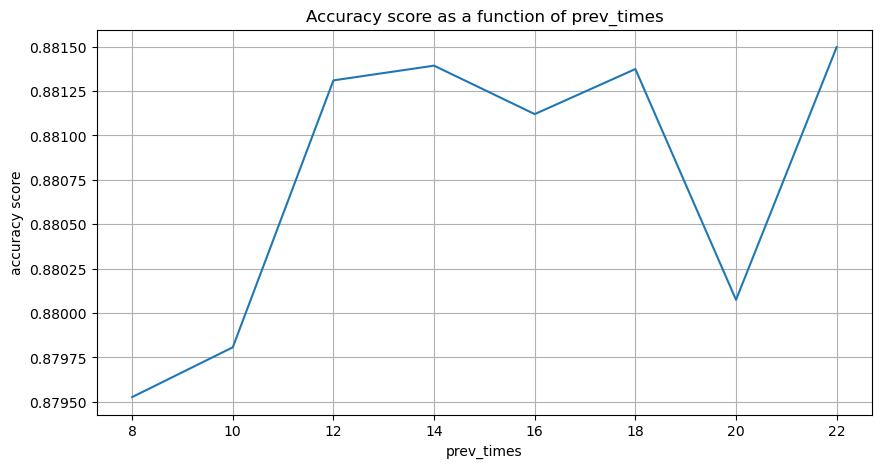

In [117]:
for i in range(len(nb_prev_times)):
    print(f' accuracy score for prev_times={nb_prev_times[i]}: {100*accuracy[i]:.2f}')
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(nb_prev_times, accuracy)
plt.xlabel('prev_times')
plt.ylabel('accuracy score')
plt.title('Accuracy score as a function of prev_times')

In [20]:
nb_prev_times_2 = [24,26,28,30]
accuracy_2 = [0,0,0,0]

In [21]:
for i, prev_times in enumerate(nb_prev_times_2):
    cnn_model_cv = CNN_model(name=f"lstm_model_cv_{prev_times}",full_data=full_data, prev_times=prev_times)
    cnn_model_cv.evaluate(n_splits=5, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)
    accuracy_2[i] = cnn_model_cv.score


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                33792     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6


6996/6999 [============================>.] - ETA: 0s - loss: 0.3123 - accuracy: 0.8665INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 103s 14ms/step - loss: 0.3123 - accuracy: 0.8665 - val_loss: 0.2970 - val_accuracy: 0.8753
Epoch 2/6
6999/6999 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.8788INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 98s 14ms/step - loss: 0.2852 - accuracy: 0.8788 - val_loss: 0.2900 - val_accuracy: 0.8773
Epoch 3/6
6999/6999 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8845INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 93s 13ms/step - loss: 0.2686 - accuracy: 0.8845 - val_loss: 0.2818 - val_accuracy: 0.8816
Epoch 4/6
6999/6999 [==============================] - 90s 13ms/step - loss: 0.2528 - accuracy: 0.8922 - val_loss: 0.2862 - val_accuracy: 0.8791
Epoch 5/6
6999/6999 [==============================] - 88s 13ms/step - loss: 0.2370 - accuracy: 0.9002 - val_loss: 0.2866 - val_accuracy: 0.8806
Epoch 6/6
6999/6999 [==============================] - 89s 13ms/step - loss: 0.2193 - accuracy: 0.9071 - val_loss: 0.2957 - val_accuracy: 0.8784



Epoch 1/6
6998/6999 [============================>.] - ETA: 0s - loss: 0.3131 - accuracy: 0.8681INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 92s 13ms/step - loss: 0.3131 - accuracy: 0.8681 - val_loss: 0.2996 - val_accuracy: 0.8723
Epoch 2/6
6999/6999 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8783INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 90s 13ms/step - loss: 0.2850 - accuracy: 0.8783 - val_loss: 0.2878 - val_accuracy: 0.8778
Epoch 3/6
6998/6999 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.8847INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 94s 13ms/step - loss: 0.2692 - accuracy: 0.8847 - val_loss: 0.2851 - val_accuracy: 0.8779
Epoch 4/6
6998/6999 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.8916INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 87s 12ms/step - loss: 0.2538 - accuracy: 0.8916 - val_loss: 0.2859 - val_accuracy: 0.8798
Epoch 5/6
6999/6999 [==============================] - 79s 11ms/step - loss: 0.2369 - accuracy: 0.8995 - val_loss: 0.2859 - val_accuracy: 0.8768
Epoch 6/6
6999/6999 [==============================] - 80s 11ms/step - loss: 0.2195 - accuracy: 0.9082 - val_loss: 0.2921 - val_accuracy: 0.8773
Epoch 1/6
6998/6999 [============================>.] - ETA: 0s - loss: 0.3127 - accuracy: 0.8687INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 87s 12ms/step - loss: 0.3128 - accuracy: 0.8686 - val_loss: 0.2970 - val_accuracy: 0.8728
Epoch 2/6
6998/6999 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.8765INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 83s 12ms/step - loss: 0.2859 - accuracy: 0.8765 - val_loss: 0.2895 - val_accuracy: 0.8762
Epoch 3/6
6998/6999 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.8849INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 83s 12ms/step - loss: 0.2696 - accuracy: 0.8849 - val_loss: 0.2857 - val_accuracy: 0.8775
Epoch 4/6
6996/6999 [============================>.] - ETA: 0s - loss: 0.2530 - accuracy: 0.8918INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 82s 12ms/step - loss: 0.2530 - accuracy: 0.8918 - val_loss: 0.2858 - val_accuracy: 0.8787
Epoch 5/6
6999/6999 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.9019INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 83s 12ms/step - loss: 0.2346 - accuracy: 0.9019 - val_loss: 0.2868 - val_accuracy: 0.8801
Epoch 6/6
6996/6999 [============================>.] - ETA: 0s - loss: 0.2175 - accuracy: 0.9089INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 84s 12ms/step - loss: 0.2175 - accuracy: 0.9089 - val_loss: 0.2885 - val_accuracy: 0.8801
Epoch 1/6
6995/6999 [============================>.] - ETA: 0s - loss: 0.3149 - accuracy: 0.8668INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 87s 12ms/step - loss: 0.3148 - accuracy: 0.8668 - val_loss: 0.2954 - val_accuracy: 0.8750
Epoch 2/6
6999/6999 [==============================] - 79s 11ms/step - loss: 0.2862 - accuracy: 0.8773 - val_loss: 0.2856 - val_accuracy: 0.8748
Epoch 3/6
6999/6999 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.8848INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 83s 12ms/step - loss: 0.2693 - accuracy: 0.8848 - val_loss: 0.2795 - val_accuracy: 0.8798
Epoch 4/6
6999/6999 [==============================] - 79s 11ms/step - loss: 0.2541 - accuracy: 0.8917 - val_loss: 0.2807 - val_accuracy: 0.8780
Epoch 5/6
6995/6999 [============================>.] - ETA: 0s - loss: 0.2377 - accuracy: 0.8986INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 84s 12ms/step - loss: 0.2377 - accuracy: 0.8986 - val_loss: 0.2826 - val_accuracy: 0.8813
Epoch 6/6
6999/6999 [==============================] - 80s 11ms/step - loss: 0.2199 - accuracy: 0.9080 - val_loss: 0.2932 - val_accuracy: 0.8799
Epoch 1/6
6995/6999 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8657INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 73s 10ms/step - loss: 0.3158 - accuracy: 0.8657 - val_loss: 0.2903 - val_accuracy: 0.8768
Epoch 2/6
6996/6999 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.8783INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 71s 10ms/step - loss: 0.2869 - accuracy: 0.8782 - val_loss: 0.2814 - val_accuracy: 0.8781
Epoch 3/6
6995/6999 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.8844INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 70s 10ms/step - loss: 0.2694 - accuracy: 0.8844 - val_loss: 0.2752 - val_accuracy: 0.8819
Epoch 4/6
6995/6999 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.8929INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_24\assets


6999/6999 [==============================] - 70s 10ms/step - loss: 0.2528 - accuracy: 0.8929 - val_loss: 0.2741 - val_accuracy: 0.8841
Epoch 5/6
6999/6999 [==============================] - 69s 10ms/step - loss: 0.2351 - accuracy: 0.9014 - val_loss: 0.2807 - val_accuracy: 0.8825
Epoch 6/6
6999/6999 [==============================] - 70s 10ms/step - loss: 0.2173 - accuracy: 0.9098 - val_loss: 0.2859 - val_accuracy: 0.8800
Accuracy score: 88.14
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                33792     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 95s 13ms/step - loss: 0.3133 - accuracy: 0.8680 - val_loss: 0.2938 - val_accuracy: 0.8780
Epoch 2/6
6992/6994 [============================>.] - ETA: 0s - loss: 0.2837 - accuracy: 0.8785INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 93s 13ms/step - loss: 0.2837 - accuracy: 0.8785 - val_loss: 0.2853 - val_accuracy: 0.8785
Epoch 3/6
6991/6994 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.8861INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 90s 13ms/step - loss: 0.2673 - accuracy: 0.8861 - val_loss: 0.2827 - val_accuracy: 0.8806
Epoch 4/6
6992/6994 [============================>.] - ETA: 0s - loss: 0.2504 - accuracy: 0.8935INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 90s 13ms/step - loss: 0.2504 - accuracy: 0.8935 - val_loss: 0.2820 - val_accuracy: 0.8817
Epoch 5/6
6994/6994 [==============================] - 87s 12ms/step - loss: 0.2334 - accuracy: 0.9019 - val_loss: 0.2863 - val_accuracy: 0.8793
Epoch 6/6
6994/6994 [==============================] - 86s 12ms/step - loss: 0.2155 - accuracy: 0.9095 - val_loss: 0.2933 - val_accuracy: 0.8751
Epoch 1/6
6994/6994 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.8680INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 95s 13ms/step - loss: 0.3131 - accuracy: 0.8680 - val_loss: 0.3051 - val_accuracy: 0.8712
Epoch 2/6
6992/6994 [============================>.] - ETA: 0s - loss: 0.2869 - accuracy: 0.8798INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 91s 13ms/step - loss: 0.2869 - accuracy: 0.8798 - val_loss: 0.2929 - val_accuracy: 0.8742
Epoch 3/6
6994/6994 [==============================] - 87s 12ms/step - loss: 0.2706 - accuracy: 0.8857 - val_loss: 0.2952 - val_accuracy: 0.8734
Epoch 4/6
6990/6994 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.8910INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 92s 13ms/step - loss: 0.2558 - accuracy: 0.8910 - val_loss: 0.2860 - val_accuracy: 0.8790
Epoch 5/6
6994/6994 [==============================] - 88s 13ms/step - loss: 0.2407 - accuracy: 0.8992 - val_loss: 0.2884 - val_accuracy: 0.8766
Epoch 6/6
6994/6994 [==============================] - 87s 12ms/step - loss: 0.2236 - accuracy: 0.9059 - val_loss: 0.2973 - val_accuracy: 0.8744
Epoch 1/6
6990/6994 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8673INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 99s 14ms/step - loss: 0.3140 - accuracy: 0.8673 - val_loss: 0.2969 - val_accuracy: 0.8735
Epoch 2/6
6994/6994 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.8780INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 102s 15ms/step - loss: 0.2858 - accuracy: 0.8780 - val_loss: 0.2821 - val_accuracy: 0.8817
Epoch 3/6
6993/6994 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8845INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 102s 15ms/step - loss: 0.2681 - accuracy: 0.8845 - val_loss: 0.2780 - val_accuracy: 0.8825
Epoch 4/6
6994/6994 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.8907INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 102s 15ms/step - loss: 0.2522 - accuracy: 0.8907 - val_loss: 0.2795 - val_accuracy: 0.8843
Epoch 5/6
6994/6994 [==============================] - 100s 14ms/step - loss: 0.2361 - accuracy: 0.8993 - val_loss: 0.2841 - val_accuracy: 0.8840
Epoch 6/6
6994/6994 [==============================] - 101s 14ms/step - loss: 0.2192 - accuracy: 0.9073 - val_loss: 0.2863 - val_accuracy: 0.8843
Epoch 1/6
6993/6994 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8665INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 115s 16ms/step - loss: 0.3165 - accuracy: 0.8665 - val_loss: 0.2878 - val_accuracy: 0.8773
Epoch 2/6
6994/6994 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8774INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 107s 15ms/step - loss: 0.2875 - accuracy: 0.8774 - val_loss: 0.2808 - val_accuracy: 0.8790
Epoch 3/6
6993/6994 [============================>.] - ETA: 0s - loss: 0.2720 - accuracy: 0.8842INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 106s 15ms/step - loss: 0.2720 - accuracy: 0.8842 - val_loss: 0.2758 - val_accuracy: 0.8812
Epoch 4/6
6994/6994 [==============================] - 101s 14ms/step - loss: 0.2562 - accuracy: 0.8909 - val_loss: 0.2741 - val_accuracy: 0.8811
Epoch 5/6
6994/6994 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.8992INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 106s 15ms/step - loss: 0.2402 - accuracy: 0.8992 - val_loss: 0.2749 - val_accuracy: 0.8849
Epoch 6/6
6994/6994 [==============================] - 103s 15ms/step - loss: 0.2224 - accuracy: 0.9070 - val_loss: 0.2855 - val_accuracy: 0.8802
Epoch 1/6
6991/6994 [============================>.] - ETA: 0s - loss: 0.3126 - accuracy: 0.8675INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 111s 15ms/step - loss: 0.3126 - accuracy: 0.8674 - val_loss: 0.2970 - val_accuracy: 0.8730
Epoch 2/6
6991/6994 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8795INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 108s 15ms/step - loss: 0.2831 - accuracy: 0.8794 - val_loss: 0.2915 - val_accuracy: 0.8758
Epoch 3/6
6992/6994 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.8868INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_26\assets


6994/6994 [==============================] - 107s 15ms/step - loss: 0.2662 - accuracy: 0.8868 - val_loss: 0.2842 - val_accuracy: 0.8791
Epoch 4/6
6994/6994 [==============================] - 103s 15ms/step - loss: 0.2490 - accuracy: 0.8953 - val_loss: 0.2875 - val_accuracy: 0.8762
Epoch 5/6
6994/6994 [==============================] - 103s 15ms/step - loss: 0.2324 - accuracy: 0.9030 - val_loss: 0.2874 - val_accuracy: 0.8789
Epoch 6/6
6994/6994 [==============================] - 103s 15ms/step - loss: 0.2145 - accuracy: 0.9114 - val_loss: 0.2984 - val_accuracy: 0.8764
Accuracy score: 88.18
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                33792     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                   

INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 109s 15ms/step - loss: 0.3156 - accuracy: 0.8673 - val_loss: 0.2983 - val_accuracy: 0.8762
Epoch 2/6
6989/6989 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.8768INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 105s 15ms/step - loss: 0.2889 - accuracy: 0.8768 - val_loss: 0.2844 - val_accuracy: 0.8778
Epoch 3/6
6987/6989 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.8830INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 105s 15ms/step - loss: 0.2739 - accuracy: 0.8830 - val_loss: 0.2788 - val_accuracy: 0.8801
Epoch 4/6
6986/6989 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.8907INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 106s 15ms/step - loss: 0.2581 - accuracy: 0.8906 - val_loss: 0.2737 - val_accuracy: 0.8849
Epoch 5/6
6989/6989 [==============================] - 100s 14ms/step - loss: 0.2428 - accuracy: 0.8968 - val_loss: 0.2791 - val_accuracy: 0.8830
Epoch 6/6
6989/6989 [==============================] - 100s 14ms/step - loss: 0.2249 - accuracy: 0.9052 - val_loss: 0.2796 - val_accuracy: 0.8825
Epoch 1/6
6985/6989 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8687INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 106s 15ms/step - loss: 0.3114 - accuracy: 0.8687 - val_loss: 0.3025 - val_accuracy: 0.8674
Epoch 2/6
6988/6989 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8786INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 100s 14ms/step - loss: 0.2853 - accuracy: 0.8787 - val_loss: 0.2918 - val_accuracy: 0.8761
Epoch 3/6
6986/6989 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.8858INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 101s 14ms/step - loss: 0.2682 - accuracy: 0.8858 - val_loss: 0.2886 - val_accuracy: 0.8766
Epoch 4/6
6989/6989 [==============================] - 95s 14ms/step - loss: 0.2524 - accuracy: 0.8941 - val_loss: 0.2866 - val_accuracy: 0.8764
Epoch 5/6
6989/6989 [==============================] - 95s 14ms/step - loss: 0.2353 - accuracy: 0.9010 - val_loss: 0.2892 - val_accuracy: 0.8762
Epoch 6/6
6989/6989 [==============================] - 95s 14ms/step - loss: 0.2173 - accuracy: 0.9098 - val_loss: 0.2962 - val_accuracy: 0.8751
Epoch 1/6
6986/6989 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8682INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 103s 14ms/step - loss: 0.3143 - accuracy: 0.8683 - val_loss: 0.3037 - val_accuracy: 0.8686
Epoch 2/6
6987/6989 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8782INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 102s 15ms/step - loss: 0.2860 - accuracy: 0.8782 - val_loss: 0.2936 - val_accuracy: 0.8756
Epoch 3/6
6988/6989 [============================>.] - ETA: 0s - loss: 0.2697 - accuracy: 0.8856INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 101s 14ms/step - loss: 0.2697 - accuracy: 0.8856 - val_loss: 0.2854 - val_accuracy: 0.8794
Epoch 4/6
6989/6989 [==============================] - 97s 14ms/step - loss: 0.2544 - accuracy: 0.8925 - val_loss: 0.2818 - val_accuracy: 0.8770
Epoch 5/6
6989/6989 [==============================] - 97s 14ms/step - loss: 0.2384 - accuracy: 0.8998 - val_loss: 0.2908 - val_accuracy: 0.8767
Epoch 6/6
6989/6989 [==============================] - 97s 14ms/step - loss: 0.2219 - accuracy: 0.9075 - val_loss: 0.2867 - val_accuracy: 0.8787
Epoch 1/6
6987/6989 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8668INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 113s 16ms/step - loss: 0.3140 - accuracy: 0.8668 - val_loss: 0.2943 - val_accuracy: 0.8766
Epoch 2/6
6986/6989 [============================>.] - ETA: 0s - loss: 0.2864 - accuracy: 0.8777INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 111s 16ms/step - loss: 0.2864 - accuracy: 0.8777 - val_loss: 0.2831 - val_accuracy: 0.8785
Epoch 3/6
6986/6989 [============================>.] - ETA: 0s - loss: 0.2702 - accuracy: 0.8850INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 111s 16ms/step - loss: 0.2702 - accuracy: 0.8850 - val_loss: 0.2809 - val_accuracy: 0.8809
Epoch 4/6
6989/6989 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.8915INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 111s 16ms/step - loss: 0.2546 - accuracy: 0.8915 - val_loss: 0.2810 - val_accuracy: 0.8811
Epoch 5/6
6989/6989 [==============================] - 111s 16ms/step - loss: 0.2374 - accuracy: 0.8999 - val_loss: 0.2861 - val_accuracy: 0.8802
Epoch 6/6
6989/6989 [==============================] - 108s 16ms/step - loss: 0.2188 - accuracy: 0.9085 - val_loss: 0.2936 - val_accuracy: 0.8804
Epoch 1/6
6987/6989 [============================>.] - ETA: 0s - loss: 0.3146 - accuracy: 0.8675INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 121s 16ms/step - loss: 0.3146 - accuracy: 0.8675 - val_loss: 0.2936 - val_accuracy: 0.8755
Epoch 2/6
6987/6989 [============================>.] - ETA: 0s - loss: 0.2855 - accuracy: 0.8790INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 114s 16ms/step - loss: 0.2855 - accuracy: 0.8790 - val_loss: 0.2854 - val_accuracy: 0.8809
Epoch 3/6
6989/6989 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.8865INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 114s 16ms/step - loss: 0.2676 - accuracy: 0.8865 - val_loss: 0.2791 - val_accuracy: 0.8819
Epoch 4/6
6989/6989 [==============================] - 111s 16ms/step - loss: 0.2509 - accuracy: 0.8934 - val_loss: 0.2855 - val_accuracy: 0.8806
Epoch 5/6
6987/6989 [============================>.] - ETA: 0s - loss: 0.2337 - accuracy: 0.9013INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_28\assets


6989/6989 [==============================] - 115s 16ms/step - loss: 0.2337 - accuracy: 0.9013 - val_loss: 0.2810 - val_accuracy: 0.8847
Epoch 6/6
6989/6989 [==============================] - 110s 16ms/step - loss: 0.2165 - accuracy: 0.9106 - val_loss: 0.2852 - val_accuracy: 0.8840
Accuracy score: 88.13
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 64)                33792     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
6984/6984 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.8667INFO:t

INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 146s 20ms/step - loss: 0.3152 - accuracy: 0.8667 - val_loss: 0.2886 - val_accuracy: 0.8748
Epoch 2/6
6984/6984 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.8779INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 140s 20ms/step - loss: 0.2858 - accuracy: 0.8779 - val_loss: 0.2832 - val_accuracy: 0.8759
Epoch 3/6
6984/6984 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.8847INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 140s 20ms/step - loss: 0.2705 - accuracy: 0.8847 - val_loss: 0.2737 - val_accuracy: 0.8801
Epoch 4/6
6984/6984 [==============================] - 135s 19ms/step - loss: 0.2536 - accuracy: 0.8930 - val_loss: 0.2774 - val_accuracy: 0.8783
Epoch 5/6
6984/6984 [==============================] - 136s 19ms/step - loss: 0.2368 - accuracy: 0.9007 - val_loss: 0.2803 - val_accuracy: 0.8791
Epoch 6/6
6984/6984 [==============================] - 136s 19ms/step - loss: 0.2200 - accuracy: 0.9091 - val_loss: 0.2866 - val_accuracy: 0.8746
Epoch 1/6
6983/6984 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8674INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 135s 19ms/step - loss: 0.3128 - accuracy: 0.8674 - val_loss: 0.2980 - val_accuracy: 0.8728
Epoch 2/6
6983/6984 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8781INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 127s 18ms/step - loss: 0.2853 - accuracy: 0.8781 - val_loss: 0.2892 - val_accuracy: 0.8786
Epoch 3/6
6984/6984 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.8847INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 128s 18ms/step - loss: 0.2690 - accuracy: 0.8847 - val_loss: 0.2833 - val_accuracy: 0.8801
Epoch 4/6
6983/6984 [============================>.] - ETA: 0s - loss: 0.2531 - accuracy: 0.8918INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 128s 18ms/step - loss: 0.2531 - accuracy: 0.8918 - val_loss: 0.2837 - val_accuracy: 0.8804
Epoch 5/6
6983/6984 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.8991INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 128s 18ms/step - loss: 0.2364 - accuracy: 0.8992 - val_loss: 0.2857 - val_accuracy: 0.8815
Epoch 6/6
6984/6984 [==============================] - 146s 21ms/step - loss: 0.2198 - accuracy: 0.9068 - val_loss: 0.2885 - val_accuracy: 0.8798
Epoch 1/6
6983/6984 [============================>.] - ETA: 0s - loss: 0.3132 - accuracy: 0.8666INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 153s 22ms/step - loss: 0.3132 - accuracy: 0.8666 - val_loss: 0.2945 - val_accuracy: 0.8761
Epoch 2/6
6983/6984 [============================>.] - ETA: 0s - loss: 0.2845 - accuracy: 0.8790INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 148s 21ms/step - loss: 0.2845 - accuracy: 0.8790 - val_loss: 0.2875 - val_accuracy: 0.8767
Epoch 3/6
6984/6984 [==============================] - 143s 20ms/step - loss: 0.2678 - accuracy: 0.8874 - val_loss: 0.2817 - val_accuracy: 0.8765
Epoch 4/6
6984/6984 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.8935INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 145s 21ms/step - loss: 0.2508 - accuracy: 0.8935 - val_loss: 0.2815 - val_accuracy: 0.8786
Epoch 5/6
6984/6984 [==============================] - 140s 20ms/step - loss: 0.2338 - accuracy: 0.9012 - val_loss: 0.2851 - val_accuracy: 0.8781
Epoch 6/6
6982/6984 [============================>.] - ETA: 0s - loss: 0.2162 - accuracy: 0.9101INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 144s 21ms/step - loss: 0.2162 - accuracy: 0.9101 - val_loss: 0.2951 - val_accuracy: 0.8796
Epoch 1/6
6983/6984 [============================>.] - ETA: 0s - loss: 0.3176 - accuracy: 0.8662INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 152s 21ms/step - loss: 0.3176 - accuracy: 0.8663 - val_loss: 0.2891 - val_accuracy: 0.8773
Epoch 2/6
6984/6984 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8767INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 145s 21ms/step - loss: 0.2886 - accuracy: 0.8767 - val_loss: 0.2810 - val_accuracy: 0.8801
Epoch 3/6
6984/6984 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.8840INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 148s 21ms/step - loss: 0.2723 - accuracy: 0.8840 - val_loss: 0.2731 - val_accuracy: 0.8829
Epoch 4/6
6984/6984 [==============================] - 139s 20ms/step - loss: 0.2580 - accuracy: 0.8913 - val_loss: 0.2757 - val_accuracy: 0.8827
Epoch 5/6
6984/6984 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.8982INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 143s 21ms/step - loss: 0.2431 - accuracy: 0.8982 - val_loss: 0.2718 - val_accuracy: 0.8851
Epoch 6/6
6984/6984 [==============================] - 140s 20ms/step - loss: 0.2261 - accuracy: 0.9053 - val_loss: 0.2766 - val_accuracy: 0.8847
Epoch 1/6
6984/6984 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8674INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 149s 21ms/step - loss: 0.3125 - accuracy: 0.8674 - val_loss: 0.3059 - val_accuracy: 0.8687
Epoch 2/6
6983/6984 [============================>.] - ETA: 0s - loss: 0.2839 - accuracy: 0.8792INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 150s 21ms/step - loss: 0.2839 - accuracy: 0.8792 - val_loss: 0.2966 - val_accuracy: 0.8726
Epoch 3/6
6984/6984 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.8864INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 147s 21ms/step - loss: 0.2674 - accuracy: 0.8864 - val_loss: 0.2866 - val_accuracy: 0.8781
Epoch 4/6
6984/6984 [==============================] - 143s 20ms/step - loss: 0.2517 - accuracy: 0.8934 - val_loss: 0.2868 - val_accuracy: 0.8777
Epoch 5/6
6982/6984 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9009INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 147s 21ms/step - loss: 0.2358 - accuracy: 0.9009 - val_loss: 0.2875 - val_accuracy: 0.8796
Epoch 6/6
6984/6984 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9094INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_30\assets


6984/6984 [==============================] - 147s 21ms/step - loss: 0.2183 - accuracy: 0.9094 - val_loss: 0.2938 - val_accuracy: 0.8801
Accuracy score: 88.13


 accuracy score for prev_times=24: 88.14
 accuracy score for prev_times=26: 88.18
 accuracy score for prev_times=28: 88.13
 accuracy score for prev_times=30: 88.13


Text(0.5, 1.0, 'Accuracy score as a function of prev_times')

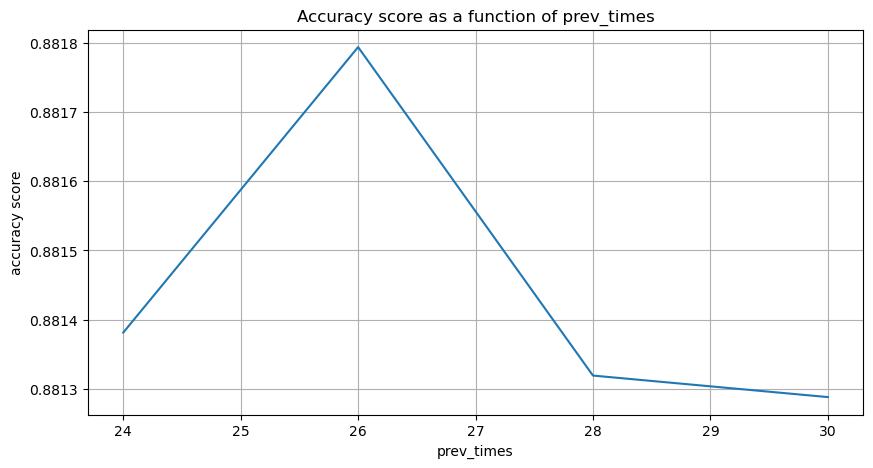

In [23]:
for i in range(len(nb_prev_times_2)):
    print(f' accuracy score for prev_times={nb_prev_times_2[i]}: {100*accuracy_2[i]:.2f}')
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(nb_prev_times_2, accuracy_2)
plt.xlabel('prev_times')
plt.ylabel('accuracy score')
plt.title('Accuracy score as a function of prev_times')

In [24]:
nb_prev_times_3 = [2,4,6,32,34,36]
accuracy_3 = [0,0,0,0,0,0]

In [25]:
for i, prev_times in enumerate(nb_prev_times_3):
    cnn_model_cv = CNN_model(name=f"lstm_model_cv_{prev_times}",full_data=full_data, prev_times=prev_times)
    cnn_model_cv.evaluate(n_splits=5, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)
    accuracy_3[i] = cnn_model_cv.score

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                33792     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7051/7056 [============================>.] - ETA: 0s - loss: 0.3181 - accuracy: 0.8653INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7056/7056 [==============================] - 65s 9ms/step - loss: 0.3180 - accuracy: 0.8654 - val_loss: 0.3031 - val_accuracy: 0.8730
Epoch 2/6
7053/7056 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8760INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7056/7056 [==============================] - 50s 7ms/step - loss: 0.2931 - accuracy: 0.8759 - val_loss: 0.2935 - val_accuracy: 0.8777
Epoch 3/6
7056/7056 [==============================] - 46s 6ms/step - loss: 0.2771 - accuracy: 0.8837 - val_loss: 0.2913 - val_accuracy: 0.8764
Epoch 4/6
7056/7056 [==============================] - 46s 6ms/step - loss: 0.2598 - accuracy: 0.8906 - val_loss: 0.2924 - val_accuracy: 0.8746
Epoch 5/6
7056/7056 [==============================] - 46s 6ms/step - loss: 0.2425 - accuracy: 0.8985 - val_loss: 0.2983 - val_accuracy: 0.8754
Epoch 6/6
7056/7056 [==============================] - 46s 7ms/step - loss: 0.2235 - accuracy: 0.9065 - val_loss: 0.3073 - val_accuracy: 0.8738
Epoch 1/6
7053/7057 [============================>.] - ETA: 0s - loss: 0.3186 - accuracy: 0.8656INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 59s 8ms/step - loss: 0.3186 - accuracy: 0.8657 - val_loss: 0.3006 - val_accuracy: 0.8727
Epoch 2/6
7050/7057 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8763INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 51s 7ms/step - loss: 0.2934 - accuracy: 0.8763 - val_loss: 0.2894 - val_accuracy: 0.8768
Epoch 3/6
7056/7057 [============================>.] - ETA: 0s - loss: 0.2765 - accuracy: 0.8832INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 50s 7ms/step - loss: 0.2765 - accuracy: 0.8832 - val_loss: 0.2877 - val_accuracy: 0.8785
Epoch 4/6
7057/7057 [==============================] - 46s 7ms/step - loss: 0.2603 - accuracy: 0.8900 - val_loss: 0.2855 - val_accuracy: 0.8782
Epoch 5/6
7057/7057 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.8977INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 50s 7ms/step - loss: 0.2426 - accuracy: 0.8977 - val_loss: 0.2857 - val_accuracy: 0.8795
Epoch 6/6
7057/7057 [==============================] - 46s 7ms/step - loss: 0.2224 - accuracy: 0.9071 - val_loss: 0.3000 - val_accuracy: 0.8758
Epoch 1/6
7057/7057 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.8672INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 67s 9ms/step - loss: 0.3166 - accuracy: 0.8672 - val_loss: 0.3125 - val_accuracy: 0.8651
Epoch 2/6
7046/7057 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8779INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 58s 8ms/step - loss: 0.2906 - accuracy: 0.8778 - val_loss: 0.2987 - val_accuracy: 0.8703
Epoch 3/6
7054/7057 [============================>.] - ETA: 0s - loss: 0.2741 - accuracy: 0.8843INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 51s 7ms/step - loss: 0.2741 - accuracy: 0.8843 - val_loss: 0.2996 - val_accuracy: 0.8722
Epoch 4/6
7052/7057 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.8927INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 50s 7ms/step - loss: 0.2568 - accuracy: 0.8927 - val_loss: 0.3009 - val_accuracy: 0.8726
Epoch 5/6
7057/7057 [==============================] - 46s 7ms/step - loss: 0.2395 - accuracy: 0.9006 - val_loss: 0.3007 - val_accuracy: 0.8725
Epoch 6/6
7057/7057 [==============================] - 46s 7ms/step - loss: 0.2204 - accuracy: 0.9088 - val_loss: 0.3161 - val_accuracy: 0.8711
Epoch 1/6
7053/7057 [============================>.] - ETA: 0s - loss: 0.3182 - accuracy: 0.8673INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 55s 7ms/step - loss: 0.3181 - accuracy: 0.8674 - val_loss: 0.3089 - val_accuracy: 0.8716
Epoch 2/6
7049/7057 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.8765INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 51s 7ms/step - loss: 0.2920 - accuracy: 0.8765 - val_loss: 0.2955 - val_accuracy: 0.8768
Epoch 3/6
7056/7057 [============================>.] - ETA: 0s - loss: 0.2755 - accuracy: 0.8835INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 52s 7ms/step - loss: 0.2755 - accuracy: 0.8835 - val_loss: 0.2908 - val_accuracy: 0.8786
Epoch 4/6
7057/7057 [==============================] - 47s 7ms/step - loss: 0.2594 - accuracy: 0.8903 - val_loss: 0.2914 - val_accuracy: 0.8766
Epoch 5/6
7057/7057 [==============================] - 47s 7ms/step - loss: 0.2418 - accuracy: 0.8988 - val_loss: 0.2945 - val_accuracy: 0.8785
Epoch 6/6
7057/7057 [==============================] - 50s 7ms/step - loss: 0.2225 - accuracy: 0.9080 - val_loss: 0.3037 - val_accuracy: 0.8765
Epoch 1/6
7050/7057 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8660INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 58s 8ms/step - loss: 0.3187 - accuracy: 0.8661 - val_loss: 0.2992 - val_accuracy: 0.8732
Epoch 2/6
7053/7057 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8755INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 53s 7ms/step - loss: 0.2930 - accuracy: 0.8755 - val_loss: 0.2928 - val_accuracy: 0.8766
Epoch 3/6
7057/7057 [==============================] - 48s 7ms/step - loss: 0.2774 - accuracy: 0.8826 - val_loss: 0.2907 - val_accuracy: 0.8762
Epoch 4/6
7055/7057 [============================>.] - ETA: 0s - loss: 0.2607 - accuracy: 0.8890INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 53s 7ms/step - loss: 0.2607 - accuracy: 0.8890 - val_loss: 0.2887 - val_accuracy: 0.8775
Epoch 5/6
7054/7057 [============================>.] - ETA: 0s - loss: 0.2427 - accuracy: 0.8972INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_2\assets


7057/7057 [==============================] - 49s 7ms/step - loss: 0.2428 - accuracy: 0.8972 - val_loss: 0.2921 - val_accuracy: 0.8788
Epoch 6/6
7057/7057 [==============================] - 44s 6ms/step - loss: 0.2235 - accuracy: 0.9065 - val_loss: 0.3027 - val_accuracy: 0.8761
Accuracy score: 87.74
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 64)                33792     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
7048/7051 [============================>.] - ETA: 0s - loss: 0.3183 - accuracy: 0.8651INFO:tenso

INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 60s 8ms/step - loss: 0.3183 - accuracy: 0.8651 - val_loss: 0.2910 - val_accuracy: 0.8762
Epoch 2/6
7050/7051 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.8758INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 55s 8ms/step - loss: 0.2916 - accuracy: 0.8758 - val_loss: 0.2859 - val_accuracy: 0.8782
Epoch 3/6
7047/7051 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.8833INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 55s 8ms/step - loss: 0.2751 - accuracy: 0.8832 - val_loss: 0.2802 - val_accuracy: 0.8827
Epoch 4/6
7051/7051 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.8916INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 55s 8ms/step - loss: 0.2568 - accuracy: 0.8916 - val_loss: 0.2817 - val_accuracy: 0.8829
Epoch 5/6
7051/7051 [==============================] - 51s 7ms/step - loss: 0.2384 - accuracy: 0.9000 - val_loss: 0.2831 - val_accuracy: 0.8829
Epoch 6/6
7051/7051 [==============================] - 49s 7ms/step - loss: 0.2185 - accuracy: 0.9085 - val_loss: 0.2941 - val_accuracy: 0.8790
Epoch 1/6
7044/7051 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8675INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 55s 7ms/step - loss: 0.3154 - accuracy: 0.8674 - val_loss: 0.3022 - val_accuracy: 0.8696
Epoch 2/6
7043/7051 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.8790INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 51s 7ms/step - loss: 0.2882 - accuracy: 0.8790 - val_loss: 0.2939 - val_accuracy: 0.8773
Epoch 3/6
7045/7051 [============================>.] - ETA: 0s - loss: 0.2705 - accuracy: 0.8843INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 51s 7ms/step - loss: 0.2705 - accuracy: 0.8843 - val_loss: 0.2894 - val_accuracy: 0.8785
Epoch 4/6
7051/7051 [==============================] - 47s 7ms/step - loss: 0.2518 - accuracy: 0.8936 - val_loss: 0.2946 - val_accuracy: 0.8764
Epoch 5/6
7051/7051 [==============================] - 48s 7ms/step - loss: 0.2331 - accuracy: 0.9017 - val_loss: 0.2962 - val_accuracy: 0.8757
Epoch 6/6
7051/7051 [==============================] - 48s 7ms/step - loss: 0.2130 - accuracy: 0.9113 - val_loss: 0.2990 - val_accuracy: 0.8757
Epoch 1/6
7044/7051 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8674INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 55s 7ms/step - loss: 0.3158 - accuracy: 0.8674 - val_loss: 0.3123 - val_accuracy: 0.8681
Epoch 2/6
7047/7051 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.8773INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 51s 7ms/step - loss: 0.2901 - accuracy: 0.8773 - val_loss: 0.2932 - val_accuracy: 0.8737
Epoch 3/6
7044/7051 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 51s 7ms/step - loss: 0.2724 - accuracy: 0.8853 - val_loss: 0.2919 - val_accuracy: 0.8747
Epoch 4/6
7048/7051 [============================>.] - ETA: 0s - loss: 0.2534 - accuracy: 0.8935INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 53s 8ms/step - loss: 0.2534 - accuracy: 0.8935 - val_loss: 0.2906 - val_accuracy: 0.8788
Epoch 5/6
7051/7051 [==============================] - 47s 7ms/step - loss: 0.2329 - accuracy: 0.9025 - val_loss: 0.3011 - val_accuracy: 0.8756
Epoch 6/6
7051/7051 [==============================] - 48s 7ms/step - loss: 0.2125 - accuracy: 0.9116 - val_loss: 0.3106 - val_accuracy: 0.8741
Epoch 1/6
7043/7051 [============================>.] - ETA: 0s - loss: 0.3151 - accuracy: 0.8678INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 56s 8ms/step - loss: 0.3152 - accuracy: 0.8677 - val_loss: 0.3048 - val_accuracy: 0.8713
Epoch 2/6
7046/7051 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8773INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 53s 7ms/step - loss: 0.2885 - accuracy: 0.8773 - val_loss: 0.2973 - val_accuracy: 0.8736
Epoch 3/6
7049/7051 [============================>.] - ETA: 0s - loss: 0.2714 - accuracy: 0.8848INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 52s 7ms/step - loss: 0.2714 - accuracy: 0.8848 - val_loss: 0.2953 - val_accuracy: 0.8748
Epoch 4/6
7049/7051 [============================>.] - ETA: 0s - loss: 0.2532 - accuracy: 0.8928INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 52s 7ms/step - loss: 0.2532 - accuracy: 0.8928 - val_loss: 0.2930 - val_accuracy: 0.8752
Epoch 5/6
7048/7051 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.9023INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 52s 7ms/step - loss: 0.2330 - accuracy: 0.9024 - val_loss: 0.2944 - val_accuracy: 0.8779
Epoch 6/6
7051/7051 [==============================] - 49s 7ms/step - loss: 0.2113 - accuracy: 0.9119 - val_loss: 0.3084 - val_accuracy: 0.8727
Epoch 1/6
7047/7051 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8664INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 50s 7ms/step - loss: 0.3162 - accuracy: 0.8663 - val_loss: 0.3013 - val_accuracy: 0.8735
Epoch 2/6
7043/7051 [============================>.] - ETA: 0s - loss: 0.2899 - accuracy: 0.8773INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 47s 7ms/step - loss: 0.2899 - accuracy: 0.8772 - val_loss: 0.2922 - val_accuracy: 0.8773
Epoch 3/6
7048/7051 [============================>.] - ETA: 0s - loss: 0.2733 - accuracy: 0.8847INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_4\assets


7051/7051 [==============================] - 47s 7ms/step - loss: 0.2733 - accuracy: 0.8847 - val_loss: 0.2903 - val_accuracy: 0.8780
Epoch 4/6
7051/7051 [==============================] - 43s 6ms/step - loss: 0.2554 - accuracy: 0.8926 - val_loss: 0.2882 - val_accuracy: 0.8777
Epoch 5/6
7051/7051 [==============================] - 44s 6ms/step - loss: 0.2353 - accuracy: 0.9013 - val_loss: 0.2913 - val_accuracy: 0.8778
Epoch 6/6
7051/7051 [==============================] - 43s 6ms/step - loss: 0.2137 - accuracy: 0.9106 - val_loss: 0.3058 - val_accuracy: 0.8774
Accuracy score: 87.92
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 64)                33792     
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                           

INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 61s 8ms/step - loss: 0.3163 - accuracy: 0.8652 - val_loss: 0.2981 - val_accuracy: 0.8751
Epoch 2/6
7046/7046 [==============================] - 54s 8ms/step - loss: 0.2878 - accuracy: 0.8757 - val_loss: 0.2956 - val_accuracy: 0.8751
Epoch 3/6
7045/7046 [============================>.] - ETA: 0s - loss: 0.2716 - accuracy: 0.8855INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 57s 8ms/step - loss: 0.2716 - accuracy: 0.8855 - val_loss: 0.2882 - val_accuracy: 0.8782
Epoch 4/6
7046/7046 [==============================] - 55s 8ms/step - loss: 0.2532 - accuracy: 0.8924 - val_loss: 0.2862 - val_accuracy: 0.8767
Epoch 5/6
7046/7046 [==============================] - 54s 8ms/step - loss: 0.2356 - accuracy: 0.9000 - val_loss: 0.2902 - val_accuracy: 0.8769
Epoch 6/6
7046/7046 [==============================] - 54s 8ms/step - loss: 0.2154 - accuracy: 0.9097 - val_loss: 0.3055 - val_accuracy: 0.8744
Epoch 1/6
7042/7046 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8669INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 61s 8ms/step - loss: 0.3144 - accuracy: 0.8669 - val_loss: 0.3016 - val_accuracy: 0.8732
Epoch 2/6
7041/7046 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.8775INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 58s 8ms/step - loss: 0.2889 - accuracy: 0.8774 - val_loss: 0.2907 - val_accuracy: 0.8770
Epoch 3/6
7041/7046 [============================>.] - ETA: 0s - loss: 0.2720 - accuracy: 0.8840INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 59s 8ms/step - loss: 0.2720 - accuracy: 0.8840 - val_loss: 0.2839 - val_accuracy: 0.8789
Epoch 4/6
7044/7046 [============================>.] - ETA: 0s - loss: 0.2550 - accuracy: 0.8927INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 58s 8ms/step - loss: 0.2550 - accuracy: 0.8926 - val_loss: 0.2883 - val_accuracy: 0.8801
Epoch 5/6
7046/7046 [==============================] - 54s 8ms/step - loss: 0.2366 - accuracy: 0.9019 - val_loss: 0.2910 - val_accuracy: 0.8772
Epoch 6/6
7046/7046 [==============================] - 54s 8ms/step - loss: 0.2170 - accuracy: 0.9104 - val_loss: 0.2932 - val_accuracy: 0.8742
Epoch 1/6
7040/7046 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8681INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 61s 8ms/step - loss: 0.3133 - accuracy: 0.8681 - val_loss: 0.3061 - val_accuracy: 0.8703
Epoch 2/6
7044/7046 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.8780INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 59s 8ms/step - loss: 0.2868 - accuracy: 0.8780 - val_loss: 0.2933 - val_accuracy: 0.8743
Epoch 3/6
7046/7046 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.8847INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 63s 9ms/step - loss: 0.2690 - accuracy: 0.8847 - val_loss: 0.2891 - val_accuracy: 0.8756
Epoch 4/6
7040/7046 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.8938INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 61s 9ms/step - loss: 0.2511 - accuracy: 0.8939 - val_loss: 0.2906 - val_accuracy: 0.8786
Epoch 5/6
7046/7046 [==============================] - 57s 8ms/step - loss: 0.2313 - accuracy: 0.9021 - val_loss: 0.2977 - val_accuracy: 0.8740
Epoch 6/6
7046/7046 [==============================] - 57s 8ms/step - loss: 0.2119 - accuracy: 0.9104 - val_loss: 0.3078 - val_accuracy: 0.8728
Epoch 1/6
7046/7046 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8661INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 66s 9ms/step - loss: 0.3164 - accuracy: 0.8661 - val_loss: 0.2948 - val_accuracy: 0.8737
Epoch 2/6
7041/7046 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8774INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 62s 9ms/step - loss: 0.2884 - accuracy: 0.8773 - val_loss: 0.2874 - val_accuracy: 0.8789
Epoch 3/6
7046/7046 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.8834INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 63s 9ms/step - loss: 0.2719 - accuracy: 0.8834 - val_loss: 0.2786 - val_accuracy: 0.8820
Epoch 4/6
7046/7046 [==============================] - 60s 8ms/step - loss: 0.2543 - accuracy: 0.8919 - val_loss: 0.2796 - val_accuracy: 0.8805
Epoch 5/6
7046/7046 [==============================] - 59s 8ms/step - loss: 0.2350 - accuracy: 0.9013 - val_loss: 0.2879 - val_accuracy: 0.8775
Epoch 6/6
7046/7046 [==============================] - 59s 8ms/step - loss: 0.2149 - accuracy: 0.9101 - val_loss: 0.2925 - val_accuracy: 0.8771
Epoch 1/6
7041/7046 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8676INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 66s 9ms/step - loss: 0.3161 - accuracy: 0.8676 - val_loss: 0.2998 - val_accuracy: 0.8733
Epoch 2/6
7046/7046 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.8763INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_6\assets


7046/7046 [==============================] - 61s 9ms/step - loss: 0.2889 - accuracy: 0.8763 - val_loss: 0.2887 - val_accuracy: 0.8791
Epoch 3/6
7046/7046 [==============================] - 57s 8ms/step - loss: 0.2714 - accuracy: 0.8850 - val_loss: 0.2849 - val_accuracy: 0.8784
Epoch 4/6
7046/7046 [==============================] - 57s 8ms/step - loss: 0.2536 - accuracy: 0.8919 - val_loss: 0.2887 - val_accuracy: 0.8775
Epoch 5/6
7046/7046 [==============================] - 58s 8ms/step - loss: 0.2341 - accuracy: 0.9007 - val_loss: 0.2922 - val_accuracy: 0.8761
Epoch 6/6
7046/7046 [==============================] - 58s 8ms/step - loss: 0.2130 - accuracy: 0.9110 - val_loss: 0.3051 - val_accuracy: 0.8754
Accuracy score: 87.96
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 64)                33792     
                                               

INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6978/6978 [==============================] - 196s 28ms/step - loss: 0.3146 - accuracy: 0.8667 - val_loss: 0.2970 - val_accuracy: 0.8769
Epoch 2/6
6977/6978 [============================>.] - ETA: 0s - loss: 0.2871 - accuracy: 0.8782INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6978/6978 [==============================] - 1567s 225ms/step - loss: 0.2871 - accuracy: 0.8782 - val_loss: 0.2875 - val_accuracy: 0.8779
Epoch 3/6
6977/6978 [============================>.] - ETA: 0s - loss: 0.2719 - accuracy: 0.8841INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6978/6978 [==============================] - 194s 28ms/step - loss: 0.2719 - accuracy: 0.8841 - val_loss: 0.2902 - val_accuracy: 0.8782
Epoch 4/6
6977/6978 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.8906INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6978/6978 [==============================] - 194s 28ms/step - loss: 0.2565 - accuracy: 0.8907 - val_loss: 0.2824 - val_accuracy: 0.8801
Epoch 5/6
6978/6978 [==============================] - 181s 26ms/step - loss: 0.2399 - accuracy: 0.8988 - val_loss: 0.2809 - val_accuracy: 0.8793
Epoch 6/6
6978/6978 [==============================] - 173s 25ms/step - loss: 0.2241 - accuracy: 0.9065 - val_loss: 0.2859 - val_accuracy: 0.8793
Epoch 1/6
6979/6979 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8677INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 188s 26ms/step - loss: 0.3146 - accuracy: 0.8677 - val_loss: 0.2977 - val_accuracy: 0.8745
Epoch 2/6
6978/6979 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8783INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 171s 25ms/step - loss: 0.2862 - accuracy: 0.8783 - val_loss: 0.2866 - val_accuracy: 0.8773
Epoch 3/6
6979/6979 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.8854INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 171s 24ms/step - loss: 0.2689 - accuracy: 0.8854 - val_loss: 0.2819 - val_accuracy: 0.8782
Epoch 4/6
6977/6979 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.8925INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 171s 24ms/step - loss: 0.2526 - accuracy: 0.8924 - val_loss: 0.2830 - val_accuracy: 0.8796
Epoch 5/6
6979/6979 [==============================] - 167s 24ms/step - loss: 0.2353 - accuracy: 0.9013 - val_loss: 0.2877 - val_accuracy: 0.8781
Epoch 6/6
6979/6979 [==============================] - 170s 24ms/step - loss: 0.2172 - accuracy: 0.9094 - val_loss: 0.2938 - val_accuracy: 0.8770
Epoch 1/6
6978/6979 [============================>.] - ETA: 0s - loss: 0.3127 - accuracy: 0.8686INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 198s 28ms/step - loss: 0.3127 - accuracy: 0.8686 - val_loss: 0.3033 - val_accuracy: 0.8704
Epoch 2/6
6978/6979 [============================>.] - ETA: 0s - loss: 0.2860 - accuracy: 0.8789INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 209s 30ms/step - loss: 0.2860 - accuracy: 0.8789 - val_loss: 0.2911 - val_accuracy: 0.8760
Epoch 3/6
6978/6979 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.8852INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 232s 33ms/step - loss: 0.2699 - accuracy: 0.8852 - val_loss: 0.2863 - val_accuracy: 0.8785
Epoch 4/6
6978/6979 [============================>.] - ETA: 0s - loss: 0.2529 - accuracy: 0.8928INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 216s 31ms/step - loss: 0.2529 - accuracy: 0.8928 - val_loss: 0.2844 - val_accuracy: 0.8801
Epoch 5/6
6978/6979 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9002INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 218s 31ms/step - loss: 0.2359 - accuracy: 0.9002 - val_loss: 0.2869 - val_accuracy: 0.8815
Epoch 6/6
6979/6979 [==============================] - 214s 31ms/step - loss: 0.2187 - accuracy: 0.9099 - val_loss: 0.2930 - val_accuracy: 0.8779
Epoch 1/6
6979/6979 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8658INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 211s 30ms/step - loss: 0.3168 - accuracy: 0.8658 - val_loss: 0.2951 - val_accuracy: 0.8738
Epoch 2/6
6978/6979 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.8771INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 205s 29ms/step - loss: 0.2876 - accuracy: 0.8771 - val_loss: 0.2807 - val_accuracy: 0.8805
Epoch 3/6
6979/6979 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.8849INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 210s 30ms/step - loss: 0.2700 - accuracy: 0.8849 - val_loss: 0.2737 - val_accuracy: 0.8827
Epoch 4/6
6979/6979 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.8918INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 197s 28ms/step - loss: 0.2543 - accuracy: 0.8918 - val_loss: 0.2722 - val_accuracy: 0.8844
Epoch 5/6
6979/6979 [==============================] - 200s 29ms/step - loss: 0.2381 - accuracy: 0.9005 - val_loss: 0.2733 - val_accuracy: 0.8842
Epoch 6/6
6979/6979 [==============================] - 202s 29ms/step - loss: 0.2196 - accuracy: 0.9079 - val_loss: 0.2767 - val_accuracy: 0.8836
Epoch 1/6
6979/6979 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8672INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 213s 30ms/step - loss: 0.3156 - accuracy: 0.8672 - val_loss: 0.2942 - val_accuracy: 0.8748
Epoch 2/6
6979/6979 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8776INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 207s 30ms/step - loss: 0.2856 - accuracy: 0.8776 - val_loss: 0.2837 - val_accuracy: 0.8774
Epoch 3/6
6979/6979 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.8838INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 206s 29ms/step - loss: 0.2687 - accuracy: 0.8838 - val_loss: 0.2850 - val_accuracy: 0.8784
Epoch 4/6
6979/6979 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.8915INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 205s 29ms/step - loss: 0.2524 - accuracy: 0.8915 - val_loss: 0.2856 - val_accuracy: 0.8797
Epoch 5/6
6979/6979 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.8996INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_32\assets


6979/6979 [==============================] - 216s 31ms/step - loss: 0.2360 - accuracy: 0.8996 - val_loss: 0.2799 - val_accuracy: 0.8833
Epoch 6/6
6979/6979 [==============================] - 208s 30ms/step - loss: 0.2192 - accuracy: 0.9081 - val_loss: 0.2896 - val_accuracy: 0.8811
Accuracy score: 88.18
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 64)                33792     
                                                                 
 dense_40 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
6973/6973 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8667INFO:t

INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 331s 47ms/step - loss: 0.3136 - accuracy: 0.8667 - val_loss: 0.2935 - val_accuracy: 0.8757
Epoch 2/6
6973/6973 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.8782INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 221s 32ms/step - loss: 0.2855 - accuracy: 0.8782 - val_loss: 0.2847 - val_accuracy: 0.8767
Epoch 3/6
6973/6973 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8857INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 208s 30ms/step - loss: 0.2686 - accuracy: 0.8857 - val_loss: 0.2795 - val_accuracy: 0.8785
Epoch 4/6
6972/6973 [============================>.] - ETA: 0s - loss: 0.2523 - accuracy: 0.8931INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 206s 30ms/step - loss: 0.2523 - accuracy: 0.8931 - val_loss: 0.2794 - val_accuracy: 0.8820
Epoch 5/6
6973/6973 [==============================] - 202s 29ms/step - loss: 0.2367 - accuracy: 0.9005 - val_loss: 0.2827 - val_accuracy: 0.8780
Epoch 6/6
6973/6973 [==============================] - 202s 29ms/step - loss: 0.2191 - accuracy: 0.9081 - val_loss: 0.2907 - val_accuracy: 0.8800
Epoch 1/6
6972/6973 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8670INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 223s 31ms/step - loss: 0.3144 - accuracy: 0.8670 - val_loss: 0.2954 - val_accuracy: 0.8735
Epoch 2/6
6973/6973 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.8776INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 218s 31ms/step - loss: 0.2862 - accuracy: 0.8776 - val_loss: 0.2858 - val_accuracy: 0.8778
Epoch 3/6
6972/6973 [============================>.] - ETA: 0s - loss: 0.2697 - accuracy: 0.8854INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 218s 31ms/step - loss: 0.2697 - accuracy: 0.8854 - val_loss: 0.2825 - val_accuracy: 0.8795
Epoch 4/6
6973/6973 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.8932INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 221s 32ms/step - loss: 0.2522 - accuracy: 0.8932 - val_loss: 0.2838 - val_accuracy: 0.8804
Epoch 5/6
6972/6973 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.8996INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 220s 32ms/step - loss: 0.2358 - accuracy: 0.8996 - val_loss: 0.2852 - val_accuracy: 0.8822
Epoch 6/6
6973/6973 [==============================] - 213s 31ms/step - loss: 0.2174 - accuracy: 0.9103 - val_loss: 0.2945 - val_accuracy: 0.8810
Epoch 1/6
6973/6973 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.8680INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 221s 31ms/step - loss: 0.3141 - accuracy: 0.8680 - val_loss: 0.3019 - val_accuracy: 0.8714
Epoch 2/6
6973/6973 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8783INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 211s 30ms/step - loss: 0.2872 - accuracy: 0.8783 - val_loss: 0.2829 - val_accuracy: 0.8787
Epoch 3/6
6972/6973 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.8854INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 214s 31ms/step - loss: 0.2699 - accuracy: 0.8854 - val_loss: 0.2770 - val_accuracy: 0.8828
Epoch 4/6
6973/6973 [==============================] - 207s 30ms/step - loss: 0.2539 - accuracy: 0.8917 - val_loss: 0.2814 - val_accuracy: 0.8781
Epoch 5/6
6973/6973 [==============================] - 206s 30ms/step - loss: 0.2377 - accuracy: 0.8999 - val_loss: 0.2830 - val_accuracy: 0.8805
Epoch 6/6
6973/6973 [==============================] - 204s 29ms/step - loss: 0.2210 - accuracy: 0.9087 - val_loss: 0.2858 - val_accuracy: 0.8807
Epoch 1/6
6973/6973 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8667INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 235s 32ms/step - loss: 0.3143 - accuracy: 0.8667 - val_loss: 0.2997 - val_accuracy: 0.8742
Epoch 2/6
6973/6973 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8777INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 222s 32ms/step - loss: 0.2869 - accuracy: 0.8777 - val_loss: 0.2872 - val_accuracy: 0.8776
Epoch 3/6
6972/6973 [============================>.] - ETA: 0s - loss: 0.2710 - accuracy: 0.8842INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 234s 34ms/step - loss: 0.2710 - accuracy: 0.8842 - val_loss: 0.2800 - val_accuracy: 0.8798
Epoch 4/6
6973/6973 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.8904INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 261s 37ms/step - loss: 0.2565 - accuracy: 0.8904 - val_loss: 0.2780 - val_accuracy: 0.8832
Epoch 5/6
6973/6973 [==============================] - 267s 38ms/step - loss: 0.2398 - accuracy: 0.8982 - val_loss: 0.2795 - val_accuracy: 0.8809
Epoch 6/6
6973/6973 [==============================] - 253s 36ms/step - loss: 0.2228 - accuracy: 0.9059 - val_loss: 0.2857 - val_accuracy: 0.8798
Epoch 1/6
6973/6973 [==============================] - ETA: 0s - loss: 0.3120 - accuracy: 0.8682INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 247s 35ms/step - loss: 0.3120 - accuracy: 0.8682 - val_loss: 0.2994 - val_accuracy: 0.8730
Epoch 2/6
6972/6973 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8789INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 247s 35ms/step - loss: 0.2830 - accuracy: 0.8790 - val_loss: 0.2920 - val_accuracy: 0.8756
Epoch 3/6
6972/6973 [============================>.] - ETA: 0s - loss: 0.2659 - accuracy: 0.8858INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 251s 36ms/step - loss: 0.2659 - accuracy: 0.8858 - val_loss: 0.2867 - val_accuracy: 0.8787
Epoch 4/6
6973/6973 [==============================] - 246s 35ms/step - loss: 0.2510 - accuracy: 0.8921 - val_loss: 0.2892 - val_accuracy: 0.8767
Epoch 5/6
6973/6973 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9001INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_34\assets


6973/6973 [==============================] - 251s 36ms/step - loss: 0.2343 - accuracy: 0.9001 - val_loss: 0.2874 - val_accuracy: 0.8803
Epoch 6/6
6973/6973 [==============================] - 247s 35ms/step - loss: 0.2167 - accuracy: 0.9086 - val_loss: 0.2949 - val_accuracy: 0.8787
Accuracy score: 88.21
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 64)                33792     
                                                                 
 dense_45 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
6968/6968 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8683INFO:t

INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 317s 45ms/step - loss: 0.3136 - accuracy: 0.8683 - val_loss: 0.2982 - val_accuracy: 0.8718
Epoch 2/6
6967/6968 [============================>.] - ETA: 0s - loss: 0.2847 - accuracy: 0.8797INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 272s 39ms/step - loss: 0.2847 - accuracy: 0.8797 - val_loss: 0.2876 - val_accuracy: 0.8750
Epoch 3/6
6968/6968 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8860INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 271s 39ms/step - loss: 0.2678 - accuracy: 0.8860 - val_loss: 0.2820 - val_accuracy: 0.8804
Epoch 4/6
6968/6968 [==============================] - 267s 38ms/step - loss: 0.2518 - accuracy: 0.8933 - val_loss: 0.2812 - val_accuracy: 0.8802
Epoch 5/6
6968/6968 [==============================] - 268s 39ms/step - loss: 0.2349 - accuracy: 0.9007 - val_loss: 0.2876 - val_accuracy: 0.8753
Epoch 6/6
6968/6968 [==============================] - 263s 38ms/step - loss: 0.2170 - accuracy: 0.9092 - val_loss: 0.2971 - val_accuracy: 0.8781
Epoch 1/6
6968/6968 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8691INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 289s 41ms/step - loss: 0.3127 - accuracy: 0.8691 - val_loss: 0.2965 - val_accuracy: 0.8729
Epoch 2/6
6968/6968 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.8792INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 284s 41ms/step - loss: 0.2837 - accuracy: 0.8792 - val_loss: 0.2889 - val_accuracy: 0.8755
Epoch 3/6
6967/6968 [============================>.] - ETA: 0s - loss: 0.2678 - accuracy: 0.8866INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 283s 41ms/step - loss: 0.2678 - accuracy: 0.8866 - val_loss: 0.2834 - val_accuracy: 0.8779
Epoch 4/6
6967/6968 [============================>.] - ETA: 0s - loss: 0.2509 - accuracy: 0.8929INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 288s 41ms/step - loss: 0.2509 - accuracy: 0.8929 - val_loss: 0.2810 - val_accuracy: 0.8819
Epoch 5/6
6968/6968 [==============================] - 287s 41ms/step - loss: 0.2348 - accuracy: 0.9015 - val_loss: 0.2871 - val_accuracy: 0.8764
Epoch 6/6
6968/6968 [==============================] - 287s 41ms/step - loss: 0.2162 - accuracy: 0.9095 - val_loss: 0.2962 - val_accuracy: 0.8778
Epoch 1/6
6968/6968 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8670INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 288s 41ms/step - loss: 0.3150 - accuracy: 0.8670 - val_loss: 0.2909 - val_accuracy: 0.8760
Epoch 2/6
6967/6968 [============================>.] - ETA: 0s - loss: 0.2855 - accuracy: 0.8793INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 276s 40ms/step - loss: 0.2855 - accuracy: 0.8792 - val_loss: 0.2790 - val_accuracy: 0.8814
Epoch 3/6
6968/6968 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.8850INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 275s 39ms/step - loss: 0.2689 - accuracy: 0.8850 - val_loss: 0.2730 - val_accuracy: 0.8848
Epoch 4/6
6968/6968 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.8923INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 265s 38ms/step - loss: 0.2538 - accuracy: 0.8923 - val_loss: 0.2719 - val_accuracy: 0.8864
Epoch 5/6
6968/6968 [==============================] - 268s 38ms/step - loss: 0.2365 - accuracy: 0.9001 - val_loss: 0.2759 - val_accuracy: 0.8848
Epoch 6/6
6968/6968 [==============================] - 273s 39ms/step - loss: 0.2193 - accuracy: 0.9086 - val_loss: 0.2811 - val_accuracy: 0.8831
Epoch 1/6
6968/6968 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8677INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 310s 44ms/step - loss: 0.3136 - accuracy: 0.8677 - val_loss: 0.2939 - val_accuracy: 0.8768
Epoch 2/6
6968/6968 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8794INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 288s 41ms/step - loss: 0.2861 - accuracy: 0.8794 - val_loss: 0.2817 - val_accuracy: 0.8795
Epoch 3/6
6967/6968 [============================>.] - ETA: 0s - loss: 0.2701 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 287s 41ms/step - loss: 0.2701 - accuracy: 0.8853 - val_loss: 0.2759 - val_accuracy: 0.8826
Epoch 4/6
6968/6968 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.8919INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 286s 41ms/step - loss: 0.2534 - accuracy: 0.8919 - val_loss: 0.2742 - val_accuracy: 0.8847
Epoch 5/6
6968/6968 [==============================] - 282s 41ms/step - loss: 0.2361 - accuracy: 0.9004 - val_loss: 0.2822 - val_accuracy: 0.8780
Epoch 6/6
6968/6968 [==============================] - 283s 41ms/step - loss: 0.2171 - accuracy: 0.9098 - val_loss: 0.2871 - val_accuracy: 0.8796
Epoch 1/6
6967/6968 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8677INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 305s 43ms/step - loss: 0.3138 - accuracy: 0.8677 - val_loss: 0.2999 - val_accuracy: 0.8747
Epoch 2/6
6967/6968 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.8786INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 296s 42ms/step - loss: 0.2856 - accuracy: 0.8786 - val_loss: 0.2953 - val_accuracy: 0.8769
Epoch 3/6
6968/6968 [==============================] - 291s 42ms/step - loss: 0.2691 - accuracy: 0.8848 - val_loss: 0.2935 - val_accuracy: 0.8767
Epoch 4/6
6968/6968 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.8919INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_36\assets


6968/6968 [==============================] - 295s 42ms/step - loss: 0.2531 - accuracy: 0.8919 - val_loss: 0.2836 - val_accuracy: 0.8794
Epoch 5/6
6968/6968 [==============================] - 300s 43ms/step - loss: 0.2370 - accuracy: 0.8996 - val_loss: 0.2882 - val_accuracy: 0.8787
Epoch 6/6
6968/6968 [==============================] - 303s 43ms/step - loss: 0.2204 - accuracy: 0.9074 - val_loss: 0.2958 - val_accuracy: 0.8777
Accuracy score: 88.26


 accuracy score for prev_times=2: 87.74
 accuracy score for prev_times=4: 87.92
 accuracy score for prev_times=6: 87.96
 accuracy score for prev_times=32: 88.18
 accuracy score for prev_times=34: 88.21
 accuracy score for prev_times=36: 88.26


Text(0.5, 1.0, 'Accuracy score as a function of prev_times')

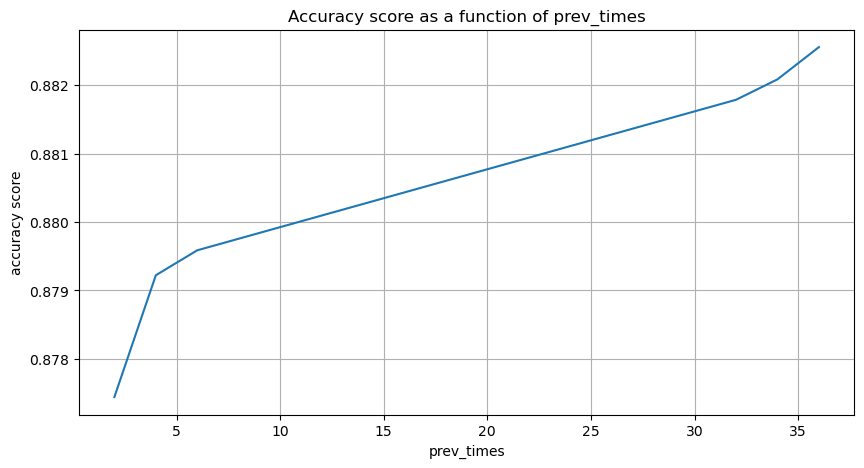

In [26]:
for i in range(len(nb_prev_times_3)):
    print(f' accuracy score for prev_times={nb_prev_times_3[i]}: {100*accuracy_3[i]:.2f}')
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(nb_prev_times_3, accuracy_3)
plt.xlabel('prev_times')
plt.ylabel('accuracy score')
plt.title('Accuracy score as a function of prev_times')

In [27]:
nb_prev_times_4 = [35,37,38]
accuracy_4 = [0,0,0]

In [28]:
for i, prev_times in enumerate(nb_prev_times_4):
    cnn_model_cv = CNN_model(name=f"lstm_model_cv_{prev_times}",full_data=full_data, prev_times=prev_times)
    cnn_model_cv.evaluate(n_splits=5, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)
    accuracy_4[i] = cnn_model_cv.score

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 64)                33792     
                                                                 
 dense_50 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
6971/6971 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.8677INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 412s 58ms/step - loss: 0.3160 - accuracy: 0.8677 - val_loss: 0.2921 - val_accuracy: 0.8750
Epoch 2/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.8777INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 352s 51ms/step - loss: 0.2877 - accuracy: 0.8777 - val_loss: 0.2830 - val_accuracy: 0.8795
Epoch 3/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.8850INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 341s 49ms/step - loss: 0.2703 - accuracy: 0.8850 - val_loss: 0.2806 - val_accuracy: 0.8804
Epoch 4/6
6971/6971 [==============================] - 333s 48ms/step - loss: 0.2549 - accuracy: 0.8910 - val_loss: 0.2803 - val_accuracy: 0.8799
Epoch 5/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9001INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 347s 50ms/step - loss: 0.2375 - accuracy: 0.9001 - val_loss: 0.2819 - val_accuracy: 0.8810
Epoch 6/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9078INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 323s 46ms/step - loss: 0.2200 - accuracy: 0.9078 - val_loss: 0.2869 - val_accuracy: 0.8814
Epoch 1/6
6971/6971 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8676INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 348s 49ms/step - loss: 0.3133 - accuracy: 0.8676 - val_loss: 0.2976 - val_accuracy: 0.8738
Epoch 2/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.8776INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 342s 49ms/step - loss: 0.2859 - accuracy: 0.8776 - val_loss: 0.2885 - val_accuracy: 0.8766
Epoch 3/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.8857INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 341s 49ms/step - loss: 0.2687 - accuracy: 0.8857 - val_loss: 0.2823 - val_accuracy: 0.8814
Epoch 4/6
6971/6971 [==============================] - 336s 48ms/step - loss: 0.2524 - accuracy: 0.8927 - val_loss: 0.2839 - val_accuracy: 0.8804
Epoch 5/6
6971/6971 [==============================] - 336s 48ms/step - loss: 0.2358 - accuracy: 0.8998 - val_loss: 0.2805 - val_accuracy: 0.8812
Epoch 6/6
6971/6971 [==============================] - 335s 48ms/step - loss: 0.2187 - accuracy: 0.9089 - val_loss: 0.2837 - val_accuracy: 0.8812
Epoch 1/6
6970/6971 [============================>.] - ETA: 0s - loss: 0.3138 - accuracy: 0.8678INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 345s 49ms/step - loss: 0.3138 - accuracy: 0.8678 - val_loss: 0.2964 - val_accuracy: 0.8748
Epoch 2/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.8786INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 334s 48ms/step - loss: 0.2847 - accuracy: 0.8786 - val_loss: 0.2924 - val_accuracy: 0.8763
Epoch 3/6
6970/6971 [============================>.] - ETA: 0s - loss: 0.2671 - accuracy: 0.8862INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 335s 48ms/step - loss: 0.2671 - accuracy: 0.8862 - val_loss: 0.2865 - val_accuracy: 0.8796
Epoch 4/6
6971/6971 [==============================] - 331s 47ms/step - loss: 0.2506 - accuracy: 0.8929 - val_loss: 0.2812 - val_accuracy: 0.8791
Epoch 5/6
6971/6971 [==============================] - 330s 47ms/step - loss: 0.2339 - accuracy: 0.9021 - val_loss: 0.2847 - val_accuracy: 0.8791
Epoch 6/6
6971/6971 [==============================] - 330s 47ms/step - loss: 0.2164 - accuracy: 0.9093 - val_loss: 0.2893 - val_accuracy: 0.8796
Epoch 1/6
6971/6971 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.8684INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 338s 48ms/step - loss: 0.3119 - accuracy: 0.8684 - val_loss: 0.3045 - val_accuracy: 0.8721
Epoch 2/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8783INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 331s 48ms/step - loss: 0.2848 - accuracy: 0.8783 - val_loss: 0.2943 - val_accuracy: 0.8738
Epoch 3/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8855INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 334s 48ms/step - loss: 0.2678 - accuracy: 0.8855 - val_loss: 0.2851 - val_accuracy: 0.8788
Epoch 4/6
6971/6971 [==============================] - 315s 45ms/step - loss: 0.2503 - accuracy: 0.8926 - val_loss: 0.2856 - val_accuracy: 0.8785
Epoch 5/6
6970/6971 [============================>.] - ETA: 0s - loss: 0.2337 - accuracy: 0.9006INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 349s 50ms/step - loss: 0.2337 - accuracy: 0.9006 - val_loss: 0.2891 - val_accuracy: 0.8793
Epoch 6/6
6971/6971 [==============================] - 366s 52ms/step - loss: 0.2157 - accuracy: 0.9107 - val_loss: 0.2960 - val_accuracy: 0.8780
Epoch 1/6
6971/6971 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.8670INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 399s 55ms/step - loss: 0.3159 - accuracy: 0.8670 - val_loss: 0.2895 - val_accuracy: 0.8760
Epoch 2/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.8767INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 420s 60ms/step - loss: 0.2890 - accuracy: 0.8767 - val_loss: 0.2802 - val_accuracy: 0.8791
Epoch 3/6
6971/6971 [==============================] - 389s 56ms/step - loss: 0.2718 - accuracy: 0.8837 - val_loss: 0.2794 - val_accuracy: 0.8783
Epoch 4/6
6971/6971 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.8913INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_35\assets


6971/6971 [==============================] - 363s 52ms/step - loss: 0.2560 - accuracy: 0.8913 - val_loss: 0.2746 - val_accuracy: 0.8815
Epoch 5/6
6971/6971 [==============================] - 328s 47ms/step - loss: 0.2379 - accuracy: 0.8999 - val_loss: 0.2760 - val_accuracy: 0.8798
Epoch 6/6
6971/6971 [==============================] - 329s 47ms/step - loss: 0.2198 - accuracy: 0.9092 - val_loss: 0.2837 - val_accuracy: 0.8802
Accuracy score: 88.06
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 64)                33792     
                                                                 
 dense_55 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6965/6965 [==============================] - 429s 61ms/step - loss: 0.3142 - accuracy: 0.8667 - val_loss: 0.2923 - val_accuracy: 0.8745
Epoch 2/6
6965/6965 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.8779INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6965/6965 [==============================] - 421s 60ms/step - loss: 0.2870 - accuracy: 0.8779 - val_loss: 0.2814 - val_accuracy: 0.8806
Epoch 3/6
6965/6965 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6965/6965 [==============================] - 420s 60ms/step - loss: 0.2699 - accuracy: 0.8853 - val_loss: 0.2761 - val_accuracy: 0.8816
Epoch 4/6
6965/6965 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.8927INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6965/6965 [==============================] - 422s 61ms/step - loss: 0.2528 - accuracy: 0.8927 - val_loss: 0.2765 - val_accuracy: 0.8825
Epoch 5/6
6965/6965 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9004INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6965/6965 [==============================] - 419s 60ms/step - loss: 0.2357 - accuracy: 0.9004 - val_loss: 0.2781 - val_accuracy: 0.8828
Epoch 6/6
6965/6965 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9093INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6965/6965 [==============================] - 420s 60ms/step - loss: 0.2178 - accuracy: 0.9093 - val_loss: 0.2820 - val_accuracy: 0.8832
Epoch 1/6
6966/6966 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.8679INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 420s 60ms/step - loss: 0.3130 - accuracy: 0.8679 - val_loss: 0.3029 - val_accuracy: 0.8748
Epoch 2/6
6966/6966 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.8787INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 419s 60ms/step - loss: 0.2849 - accuracy: 0.8787 - val_loss: 0.2946 - val_accuracy: 0.8775
Epoch 3/6
6965/6966 [============================>.] - ETA: 0s - loss: 0.2687 - accuracy: 0.8853INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 411s 59ms/step - loss: 0.2687 - accuracy: 0.8853 - val_loss: 0.2909 - val_accuracy: 0.8813
Epoch 4/6
6966/6966 [==============================] - 407s 58ms/step - loss: 0.2519 - accuracy: 0.8919 - val_loss: 0.2851 - val_accuracy: 0.8800
Epoch 5/6
6966/6966 [==============================] - 461s 66ms/step - loss: 0.2354 - accuracy: 0.9003 - val_loss: 0.2905 - val_accuracy: 0.8768
Epoch 6/6
6966/6966 [==============================] - 430s 62ms/step - loss: 0.2173 - accuracy: 0.9091 - val_loss: 0.2926 - val_accuracy: 0.8813
Epoch 1/6
6965/6966 [============================>.] - ETA: 0s - loss: 0.3154 - accuracy: 0.8664INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 423s 60ms/step - loss: 0.3154 - accuracy: 0.8664 - val_loss: 0.2941 - val_accuracy: 0.8760
Epoch 2/6
6965/6966 [============================>.] - ETA: 0s - loss: 0.2860 - accuracy: 0.8787INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 413s 59ms/step - loss: 0.2860 - accuracy: 0.8787 - val_loss: 0.2818 - val_accuracy: 0.8772
Epoch 3/6
6965/6966 [============================>.] - ETA: 0s - loss: 0.2703 - accuracy: 0.8866INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 412s 59ms/step - loss: 0.2703 - accuracy: 0.8866 - val_loss: 0.2775 - val_accuracy: 0.8831
Epoch 4/6
6966/6966 [==============================] - 408s 59ms/step - loss: 0.2546 - accuracy: 0.8920 - val_loss: 0.2754 - val_accuracy: 0.8825
Epoch 5/6
6966/6966 [==============================] - 407s 58ms/step - loss: 0.2384 - accuracy: 0.8989 - val_loss: 0.2811 - val_accuracy: 0.8828
Epoch 6/6
6966/6966 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9059INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 412s 59ms/step - loss: 0.2220 - accuracy: 0.9059 - val_loss: 0.2813 - val_accuracy: 0.8834
Epoch 1/6
6966/6966 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8680INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 434s 60ms/step - loss: 0.3135 - accuracy: 0.8680 - val_loss: 0.2996 - val_accuracy: 0.8719
Epoch 2/6
6965/6966 [============================>.] - ETA: 0s - loss: 0.2851 - accuracy: 0.8788INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 420s 60ms/step - loss: 0.2850 - accuracy: 0.8788 - val_loss: 0.2871 - val_accuracy: 0.8762
Epoch 3/6
6965/6966 [============================>.] - ETA: 0s - loss: 0.2671 - accuracy: 0.8865INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 418s 60ms/step - loss: 0.2671 - accuracy: 0.8865 - val_loss: 0.2797 - val_accuracy: 0.8794
Epoch 4/6
6965/6966 [============================>.] - ETA: 0s - loss: 0.2504 - accuracy: 0.8933INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 418s 60ms/step - loss: 0.2504 - accuracy: 0.8933 - val_loss: 0.2810 - val_accuracy: 0.8795
Epoch 5/6
6966/6966 [==============================] - 413s 59ms/step - loss: 0.2335 - accuracy: 0.9010 - val_loss: 0.2869 - val_accuracy: 0.8794
Epoch 6/6
6966/6966 [==============================] - 414s 59ms/step - loss: 0.2170 - accuracy: 0.9101 - val_loss: 0.2900 - val_accuracy: 0.8785
Epoch 1/6
6966/6966 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8673INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 462s 65ms/step - loss: 0.3145 - accuracy: 0.8673 - val_loss: 0.2936 - val_accuracy: 0.8743
Epoch 2/6
6966/6966 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.8787INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 1163s 167ms/step - loss: 0.2852 - accuracy: 0.8787 - val_loss: 0.2835 - val_accuracy: 0.8781
Epoch 3/6
6966/6966 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.8846INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_37\assets


6966/6966 [==============================] - 582s 84ms/step - loss: 0.2696 - accuracy: 0.8846 - val_loss: 0.2838 - val_accuracy: 0.8788
Epoch 4/6
6966/6966 [==============================] - 606s 87ms/step - loss: 0.2542 - accuracy: 0.8912 - val_loss: 0.2786 - val_accuracy: 0.8787
Epoch 5/6
6966/6966 [==============================] - 689s 99ms/step - loss: 0.2392 - accuracy: 0.8989 - val_loss: 0.2824 - val_accuracy: 0.8783
Epoch 6/6
6966/6966 [==============================] - 524s 75ms/step - loss: 0.2229 - accuracy: 0.9070 - val_loss: 0.2880 - val_accuracy: 0.8756
Accuracy score: 88.12
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 64)                33792     
                                                                 
 dense_60 (Dense)            (None, 1)                 65        
                                                   

 accuracy score for prev_times=2: 87.74
 accuracy score for prev_times=4: 87.92
 accuracy score for prev_times=6: 87.96
 accuracy score for prev_times=32: 88.18
 accuracy score for prev_times=34: 88.21
 accuracy score for prev_times=36: 88.26


Text(0.5, 1.0, 'Accuracy score as a function of prev_times')

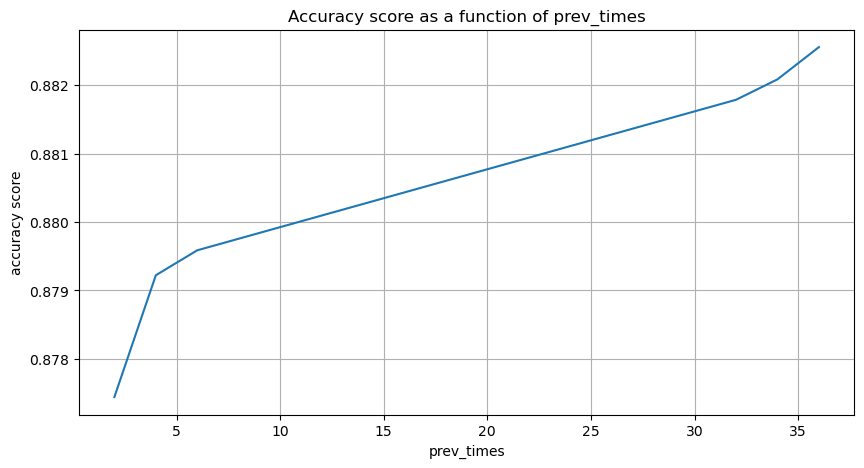

In [ ]:
for i in range(len(nb_prev_times_4)):
    print(f' accuracy score for prev_times={nb_prev_times_4[i]}: {100*accuracy_4[i]:.2f}')
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(nb_prev_times_4, accuracy_4)
plt.xlabel('prev_times')
plt.ylabel('accuracy score')
plt.title('Accuracy score as a function of prev_times')

### 45 DAYS SEQUENCE : Test on one Train-Test split (accuracy : 88.36%)

In [87]:
lstm_model_45 = LSTM_model(name="lstm_model_45",full_data=full_data, prev_times=45)

In [88]:
lstm_model_45.evaluate(n_splits=1, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 64)                33792     
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
6945/6945 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.8670INFO:tensorflow:Assets written to: best_lstm_model_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_30\assets


6945/6945 [==============================] - 299s 42ms/step - loss: 0.3147 - accuracy: 0.8670 - val_loss: 0.2942 - val_accuracy: 0.8770
Epoch 2/6
6945/6945 [==============================] - 274s 39ms/step - loss: 0.2855 - accuracy: 0.8773 - val_loss: 0.2919 - val_accuracy: 0.8756
Epoch 3/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.2683 - accuracy: 0.8870INFO:tensorflow:Assets written to: best_lstm_model_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_30\assets


6945/6945 [==============================] - 240s 35ms/step - loss: 0.2683 - accuracy: 0.8870 - val_loss: 0.2774 - val_accuracy: 0.8818
Epoch 4/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.8927INFO:tensorflow:Assets written to: best_lstm_model_30\assets


INFO:tensorflow:Assets written to: best_lstm_model_30\assets


6945/6945 [==============================] - 228s 33ms/step - loss: 0.2511 - accuracy: 0.8926 - val_loss: 0.2787 - val_accuracy: 0.8836
Epoch 5/6
6945/6945 [==============================] - 215s 31ms/step - loss: 0.2351 - accuracy: 0.9007 - val_loss: 0.2777 - val_accuracy: 0.8821
Epoch 6/6
6945/6945 [==============================] - 214s 31ms/step - loss: 0.2169 - accuracy: 0.9102 - val_loss: 0.2849 - val_accuracy: 0.8828
Accuracy score: 88.36


In [90]:
print(lstm_model_45.name + f' accuracy score : {100*lstm_model_45.score:.2f}')

lstm_model_30 accuracy score : 88.36


### 45 DAYS SEQUENCE : Cross-Validation (accuracy : 88.09%)

In [91]:
lstm_model_cv_45 = LSTM_model(name="lstm_model_cv_45",full_data=full_data, prev_times=45)

In [92]:
lstm_model_cv_45.evaluate(n_splits=5, learning_rate=0.001, epochs=6, batch_size=8, use_model_checkpoint=True)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 64)                33792     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33857 (132.25 KB)
Trainable params: 33857 (132.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/6
6945/6945 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.8674INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 288s 41ms/step - loss: 0.3132 - accuracy: 0.8674 - val_loss: 0.2958 - val_accuracy: 0.8767
Epoch 2/6
6945/6945 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.8775INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 259s 37ms/step - loss: 0.2858 - accuracy: 0.8775 - val_loss: 0.2896 - val_accuracy: 0.8788
Epoch 3/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.8841INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 220s 32ms/step - loss: 0.2700 - accuracy: 0.8841 - val_loss: 0.2815 - val_accuracy: 0.8797
Epoch 4/6
6945/6945 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.8913INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 213s 31ms/step - loss: 0.2537 - accuracy: 0.8913 - val_loss: 0.2791 - val_accuracy: 0.8824
Epoch 5/6
6945/6945 [==============================] - 207s 30ms/step - loss: 0.2375 - accuracy: 0.8998 - val_loss: 0.2812 - val_accuracy: 0.8802
Epoch 6/6
6945/6945 [==============================] - 208s 30ms/step - loss: 0.2202 - accuracy: 0.9081 - val_loss: 0.2880 - val_accuracy: 0.8782
Epoch 1/6
6945/6945 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.8667INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 225s 31ms/step - loss: 0.3147 - accuracy: 0.8667 - val_loss: 0.2926 - val_accuracy: 0.8760
Epoch 2/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.8775INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 213s 31ms/step - loss: 0.2868 - accuracy: 0.8775 - val_loss: 0.2840 - val_accuracy: 0.8780
Epoch 3/6
6945/6945 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8845INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 210s 30ms/step - loss: 0.2710 - accuracy: 0.8845 - val_loss: 0.2806 - val_accuracy: 0.8809
Epoch 4/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.2550 - accuracy: 0.8914INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 209s 30ms/step - loss: 0.2549 - accuracy: 0.8914 - val_loss: 0.2765 - val_accuracy: 0.8818
Epoch 5/6
6945/6945 [==============================] - 206s 30ms/step - loss: 0.2380 - accuracy: 0.8998 - val_loss: 0.2850 - val_accuracy: 0.8801
Epoch 6/6
6945/6945 [==============================] - 206s 30ms/step - loss: 0.2196 - accuracy: 0.9079 - val_loss: 0.2919 - val_accuracy: 0.8818
Epoch 1/6
6945/6945 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8685INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 219s 31ms/step - loss: 0.3116 - accuracy: 0.8685 - val_loss: 0.3009 - val_accuracy: 0.8706
Epoch 2/6
6945/6945 [==============================] - 206s 30ms/step - loss: 0.2831 - accuracy: 0.8801 - val_loss: 0.2937 - val_accuracy: 0.8703
Epoch 3/6
6945/6945 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.8860INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 210s 30ms/step - loss: 0.2662 - accuracy: 0.8860 - val_loss: 0.2913 - val_accuracy: 0.8741
Epoch 4/6
6945/6945 [==============================] - 204s 29ms/step - loss: 0.2502 - accuracy: 0.8931 - val_loss: 0.2900 - val_accuracy: 0.8725
Epoch 5/6
6945/6945 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9010INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 209s 30ms/step - loss: 0.2342 - accuracy: 0.9010 - val_loss: 0.2960 - val_accuracy: 0.8767
Epoch 6/6
6945/6945 [==============================] - 205s 30ms/step - loss: 0.2166 - accuracy: 0.9092 - val_loss: 0.3024 - val_accuracy: 0.8748
Epoch 1/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8668INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 227s 32ms/step - loss: 0.3153 - accuracy: 0.8668 - val_loss: 0.3013 - val_accuracy: 0.8731
Epoch 2/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8772INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 208s 30ms/step - loss: 0.2872 - accuracy: 0.8772 - val_loss: 0.2864 - val_accuracy: 0.8807
Epoch 3/6
6945/6945 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.8852INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 208s 30ms/step - loss: 0.2705 - accuracy: 0.8852 - val_loss: 0.2815 - val_accuracy: 0.8825
Epoch 4/6
6945/6945 [==============================] - 204s 29ms/step - loss: 0.2558 - accuracy: 0.8917 - val_loss: 0.2775 - val_accuracy: 0.8818
Epoch 5/6
6945/6945 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.8989INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 208s 30ms/step - loss: 0.2393 - accuracy: 0.8989 - val_loss: 0.2804 - val_accuracy: 0.8830
Epoch 6/6
6945/6945 [==============================] - 204s 29ms/step - loss: 0.2223 - accuracy: 0.9059 - val_loss: 0.2880 - val_accuracy: 0.8773
Epoch 1/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8671INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 231s 33ms/step - loss: 0.3141 - accuracy: 0.8671 - val_loss: 0.2932 - val_accuracy: 0.8731
Epoch 2/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8776INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 222s 32ms/step - loss: 0.2861 - accuracy: 0.8776 - val_loss: 0.2859 - val_accuracy: 0.8775
Epoch 3/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.8850INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 222s 32ms/step - loss: 0.2694 - accuracy: 0.8850 - val_loss: 0.2855 - val_accuracy: 0.8780
Epoch 4/6
6944/6945 [============================>.] - ETA: 0s - loss: 0.2548 - accuracy: 0.8911INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 222s 32ms/step - loss: 0.2547 - accuracy: 0.8912 - val_loss: 0.2808 - val_accuracy: 0.8793
Epoch 5/6
6945/6945 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.8992INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


INFO:tensorflow:Assets written to: best_lstm_model_cv_45)\assets


6945/6945 [==============================] - 244s 35ms/step - loss: 0.2394 - accuracy: 0.8992 - val_loss: 0.2851 - val_accuracy: 0.8803
Epoch 6/6
6945/6945 [==============================] - 276s 40ms/step - loss: 0.2212 - accuracy: 0.9083 - val_loss: 0.2937 - val_accuracy: 0.8795
Accuracy score: 88.09


In [93]:
print(lstm_model_cv_45.name + f' accuracy score : {100*lstm_model_cv_45.score:.2f}')

lstm_model_cv_45) accuracy score : 88.09
